In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from pathlib import Path
from skimage import io, util, morphology
import pprint

plt.ion()

# Configuration and Experiment Parameters

In [163]:
PATH = Path('/media/bread/wdblue/deep_image_matting/Combined_Dataset/Training_set')
TEST = Path('/media/bread/wdblue/deep_image_matting/Combined_Dataset/Test_set/Adobe-licensed images')
TRIMAPS = PATH/'trimap'
TEST_TRI = TEST/'trimaps'
TEST_MASK = Path('/media/bread/wdblue/deep_image_matting/Combined_Dataset/Test_set/Adobe-licensed images/alpha')
TRAIN = PATH/'merged'
FG = Path('fg')
BG = Path('bg')
MASKS = PATH/'mask'

## Trimap Generation and Testing *Consider alpha channel instead of only the first channel

In [272]:
np.set_printoptions(threshold=np.nan)
fn = os.listdir(TEST_MASK)[0]
im = io.imread(TEST/'fg'/fn)
m = (io.imread(TEST_MASK/fn))[:,:,0]
mask = (io.imread(TEST_MASK/fn))
tri = io.imread((TEST_TRI/(fn[:-4]+'_0.png')))
mask.shape, m.shape, tri.shape, im.shape

((1920, 1762, 4), (1920, 1762), (1920, 1762), (1920, 1762, 4))

In [89]:
def mapto255(x):
    if(x > 0):
        return 255
    else:
        return 0
    
vmap = np.vectorize(mapto255)

In [273]:
def mapto255_2(x):
    if(x > 191):
        return 255
    else:
        return 0
    
vmap2 = np.vectorize(mapto255_2)

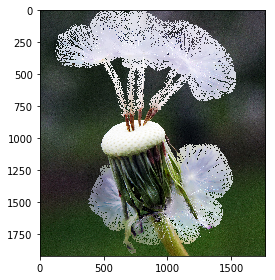

In [274]:
io.imshow(im)

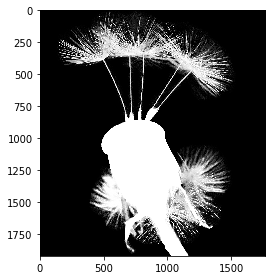

In [275]:
io.imshow(m)

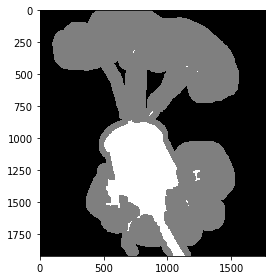

In [278]:
kernel = np.ones((35,35), np.uint8)
k2 = np.ones((35,35), np.uint8)
io.imshow(((0.5 * morphology.dilation(vmap(m), kernel))+(0.5 * morphology.erosion(vmap2(m), k2))).astype(np.uint8))

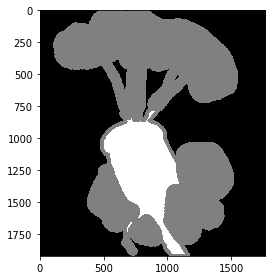

In [279]:
io.imshow(tri)

In [280]:
# # Create and save trimaps from ground-truth masks
# kernel = np.ones((35,35), np.uint8)
# for fn in os.listdir(MASKS):
#     im = io.imread(MASKS/fn)
#     if(len(im.shape) == 3):
#         im = im[:,:,0]
#     trimap = ((0.5 * morphology.dilation(vmap(im), kernel))+(0.5 * morphology.erosion(vmap2(im), kernel))).astype(np.uint8)
#     io.imsave(TRIMAPS/(fn[:-3] + 'png'), trimap)

# Build Dataloader with Transforms

In [88]:
# Helper function to deal with filename structure
# Each image of a foreground with a ground-truth matte is composited on hundreds of backgrounds
def find_last_idx(s):
    idx = -1
    while(True):
        try:
            new_idx = s[idx+1:].index('_')
            idx = idx + new_idx + 1
        except:
            return idx

In [281]:
class MatteDataset(Dataset):    
    def __init__(self, filenames, root_dir, transform=None):
        self.fns = filenames
        self.root_dir = root_dir
        self.transform = transform
        self.kernel = np.ones((32,32), np.uint8)
        
    def __len__(self):
        return len(self.fns)
    
    def __getitem__(self, idx):
        print("opening im ", self.fns[idx])
        img_path = os.path.join(self.root_dir,
                                'merged',
                                self.fns[idx])
        midx = find_last_idx(self.fns[idx])
        mask_path = os.path.join(self.root_dir,
                                 'mask',
                                 self.fns[idx][:midx]+'.jpg')
        trimap_path = os.path.join(self.root_dir,
                                 'trimap',
                                 self.fns[idx][:midx]+'.png')
        image = io.imread(img_path)
        mask = io.imread(mask_path).astype(np.uint8)
        trimap = io.imread(trimap_path)
        if(len(mask.shape) == 3):
            mask = mask[:,:,0]
        
        if self.transform:
            image, trimap, mask = self.transform(image), self.transform(trimap), self.transform(np.expand_dims(mask, 2))
            
        sample = {'image': image, 'trimap': trimap, 'mask': mask}
        
        print("closing im ", self.fns[idx])
        return sample

In [282]:
class ToNumpy(object):
    """Convert a ``PIL Image`` to ``numpy.ndarray``

    """

    def __call__(self, pic):
        """
        Args:
            pic (PIL Image): Image to be converted to ndarray.
        Returns:
            ndarray: Converted image.
        """
        return np.array(pic)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [283]:
# Augmentation with transformations

data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(4),
    transforms.RandomHorizontalFlip(),
    ToNumpy()
#     transforms.ToTensor()
])

In [284]:
# saltset_t = SaltDataset(csv_file='train.csv', root_dir=PATH, transform=data_transform)
ds = MatteDataset(os.listdir(TRAIN), root_dir=PATH)

In [289]:
dl = DataLoader(ds, batch_size=1, shuffle=True, num_workers=1)

In [290]:
for i, data in enumerate(dl):
#     if(i == 1):
#         break
    im = data['image']
    m = data['mask']
    tri = data['trimap']
    print(im.shape, m.shape, tri.shape)

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fc9b86be470>>
Traceback (most recent call last):
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


opening im  GT22_7.png
closing im  GT22_7.png
opening im  godiva_close_00025_3.png
closing im  godiva_close_00025_3.png
opening im  milk_86.png
torch.Size([1, 719, 800, 3]) torch.Size([1, 719, 800]) torch.Size([1, 719, 800])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
closing im  milk_86.png
opening im  locked_00060_4.png
closing im  locked_00060_4.png
opening im  035A4449_50.png
closing im  035A4449_50.png
opening im  small-flower-202724_1920_47.png
torch.Size([1, 4000, 6016, 3]) torch.Size([1, 4000, 6016]) torch.Size([1, 4000, 6016])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1362, 3]) torch.Size([1, 1067, 1362]) torch.Size([1, 1067, 1362])
closing im  small-flower-202724_1920_47.png
opening im  5523655465_d3b4eac71f_b_17.png
closing im  5523655465_d3b4eac71f_b_17.png
opening im  archeology_00180_62.png
closing im  archeology_00180_62.png
opening im  mmtest_00060_2.png
closing im  mmtest_0

closing im  blur_00005_74.png
opening im  godiva_close_00035_30.png
closing im  godiva_close_00035_30.png
opening im  income-996554_1920_43.png
closing im  income-996554_1920_43.png
opening im  woman-804072_960_720_46.png
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 1254, 1920, 3]) torch.Size([1, 1254, 1920]) torch.Size([1, 1254, 1920])
closing im  woman-804072_960_720_46.png
opening im  with_wings___pose_reference_by_senshistock-d6by42n_46.png
closing im  with_wings___pose_reference_by_senshistock-d6by42n_46.png
opening im  035A4553_93.png
closing im  035A4553_93.png
opening im  GT17_18.png
closing im  GT17_18.png
opening im  blur_00035_52.png
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
torch.Size([1, 565, 529, 3]) torch.Size([1, 565, 529]) torch.Size([1, 565, 529])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1

closing im  mmtest_00000_2.png
opening im  girl-1535859_1920_58.png
closing im  girl-1535859_1920_58.png
opening im  archeology_00215_93.png
closing im  archeology_00215_93.png
opening im  arrgh___r___30_by_mjranum_stock_62.png
closing im  arrgh___r___30_by_mjranum_stock_62.png
opening im  fashion-model-portrait_10.png
closing im  fashion-model-portrait_10.png
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1920, 1280, 3]) torch.Size([1, 1920, 1280]) torch.Size([1, 1920, 1280])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 724, 600, 3]) torch.Size([1, 724, 600]) torch.Size([1, 724, 600])
opening im  clematis-vitalba-99887_1920_63.png
closing im  clematis-vitalba-99887_1920_63.png
opening im  locked_00045_71.png
closing im  locked_00045_71.png
opening im  035A4542_57.png
torch.Size([1, 615, 410, 3]) torch.Size([1, 615, 410]) torch.Size([1, 615, 410])
torch.Size([1, 854, 1743, 3]) torch.Size

closing im  Lava_the_sled_dog_78.png
opening im  035A4552_59.png
closing im  035A4552_59.png
opening im  archeology_00210_38.png
closing im  archeology_00210_38.png
opening im  arrgh___r___29_by_mjranum_stock_45.png
closing im  arrgh___r___29_by_mjranum_stock_45.png
opening im  mmtest_00160_95.png
closing im  mmtest_00160_95.png
opening im  035A4340_7.png
torch.Size([1, 2400, 3604, 3]) torch.Size([1, 2400, 3604]) torch.Size([1, 2400, 3604])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 887, 600, 3]) torch.Size([1, 887, 600]) torch.Size([1, 887, 600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  035A4340_7.png
opening im  archeology_00075_66.png
closing im  archeology_00075_66.png
opening im  locked_00070_60.png
closing im  locked_00070_60.png
opening im  women-878869_1920_94.png
closing im  women-878869_

closing im  035A4436_51.png
opening im  archeology_00125_0.png
closing im  archeology_00125_0.png
opening im  17620-a-beautiful-woman-in-a-bikini-pv_45.png
closing im  17620-a-beautiful-woman-in-a-bikini-pv_45.png
opening im  cobweb-1160456_1920_65.png
closing im  cobweb-1160456_1920_65.png
opening im  ballerina-855652_1920_43.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 561, 506, 3]) torch.Size([1, 561, 506]) torch.Size([1, 561, 506])
torch.Size([1, 1427, 1920, 3]) torch.Size([1, 1427, 1920]) torch.Size([1, 1427, 1920])
closing im  ballerina-855652_1920_43.png
opening im  archeology_00110_56.png
closing im  archeology_00110_56.png
opening im  GT10_64.png
closing im  GT10_64.png
opening im  person-woman-eyes-face_70.png
torch.Size([1, 839, 1920, 3]) torch.Size([1, 839, 1920]) torch.Size([1, 839, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 

closing im  035A4508_79.png
opening im  035A4474_89.png
closing im  035A4474_89.png
opening im  locked_00075_8.png
closing im  locked_00075_8.png
opening im  035A4310_47.png
closing im  035A4310_47.png
opening im  035A4456_65.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  035A4456_65.png
opening im  035A4304_57.png
closing im  035A4304_57.png
opening im  fern-886924_1920_18.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  fern-886924_1920_18.png
opening im  mmtest_00130_71.png
closing im  mmtest_00130_71.png
opening im  GT04_82.png
closing im

closing im  035A4532_55.png
opening im  woman-868519_960_720_32.png
closing im  woman-868519_960_720_32.png
opening im  archeology_00040_91.png
closing im  archeology_00040_91.png
opening im  pink-hair-855660_960_720_8.png
closing im  pink-hair-855660_960_720_8.png
opening im  man_headshot_82.png
closing im  man_headshot_82.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
opening im  milk-518067_1920_14.png
closing im  milk-518067_1920_14.png
opening im  Model_in_green_dress_3_7.png
closing im  Model_in_green_dress_3_7.png
opening im  8688417335_01f3bafbe5_o_77.png
torch.Size([1, 1568, 1712, 3]) torch.Size([1, 1568, 1712]) torch.Size([1, 1568, 1712])
torch.Size([1, 1517, 1920, 3]) torch.Size([1, 1517, 1920

closing im  035A4545_53.png
opening im  GT08_63.png
torch.Size([1, 5184, 3456, 3]) torch.Size([1, 5184, 3456]) torch.Size([1, 5184, 3456])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  GT08_63.png
opening im  blur_00030_74.png
closing im  blur_00030_74.png
opening im  smoke_00035_48.png
closing im  smoke_00035_48.png
opening im  mmtest_00185_89.png
closing im  mmtest_00185_89.png
opening im  5892503248_4b882863c7_o_89.png
torch.Size([1, 800, 647, 3]) torch.Size([1, 800, 647]) torch.Size([1, 800, 647])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  5892503248_4b882863c7_o_89.png
opening im  035A4458_6.png
closing im  035A4458_6.png
opening

closing im  archeology_00125_1.png
opening im  woman-1138435_960_720_80.png
closing im  woman-1138435_960_720_80.png
opening im  035A4334_44.png
closing im  035A4334_44.png
opening im  bonsai-316573_1280_30.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  bonsai-316573_1280_30.png
opening im  archeology_00075_15.png
closing im  archeology_00075_15.png
opening im  mmtest_00025_4.png
closing im  mmtest_00025_4.png
opening im  035A4329_11.png
closing im  035A4329_11.png
opening im  mmtest_00045_56.png
closing im  mmtest_00045_56.png
opening im  caterpillar-205204_1920_8.png
torch.Size([1, 1156, 1280, 3]) torch.Size([1, 1156, 1280]) torch.Size([1, 1156, 1280])
torch.Size([1, 540, 640, 3]) tor

opening im  035A4331_22.png
closing im  035A4331_22.png
opening im  4804813050_e7b359d2c9_o_29.png
torch.Size([1, 1517, 1920, 3]) torch.Size([1, 1517, 1920]) torch.Size([1, 1517, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  4804813050_e7b359d2c9_o_29.png
opening im  tree-fern-420073_1920_85.png
closing im  tree-fern-420073_1920_85.png
opening im  godiva_close_00015_0.png
closing im  godiva_close_00015_0.png
opening im  035A4531_76.png
torch.Size([1, 2634, 2634, 3]) torch.Size([1, 2634, 2634]) torch.Size([1, 2634, 2634])
torch.Size([1, 1280, 1442, 3]) torch.Size([1, 1280, 1442]) torch.Size([1, 1280, 1442])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
closing im  035A4531_76.png
opening im  archeology_00210_24.png
closing im  archeology_00210_24.png
opening im  alpaca-18009_1920_60.png
closing im  alpaca-18009_19

closing im  cat-1069990_1920_45.png
opening im  035A4529_61.png
closing im  035A4529_61.png
opening im  mmtest_00015_81.png
closing im  mmtest_00015_81.png
opening im  model-610352_960_720_93.png
closing im  model-610352_960_720_93.png
opening im  GT05_74.png
closing im  GT05_74.png
opening im  035A4528_50.png
torch.Size([1, 1362, 1920, 3]) torch.Size([1, 1362, 1920]) torch.Size([1, 1362, 1920])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 465, 313, 3]) torch.Size([1, 465, 313]) torch.Size([1, 465, 313])
torch.Size([1, 552, 800, 3])closing im  035A4528_50.png
opening im  Motivate_(Fitness_model)_4.png
 torch.Size([1, 552, 800]) torch.Size([1, 552, 800])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  Motivate_(Fitness_model)_4.png
opening im  ice-winter-weather-cold-42266_90.png
closing im  ice-winte

closing im  mmtest_00010_55.png
opening im  dog-1203228_960_720_71.png
closing im  dog-1203228_960_720_71.png
opening im  sorcery___8_by_mjranum_stock_41.png
closing im  sorcery___8_by_mjranum_stock_41.png
opening im  035A4545_92.png
torch.Size([1, 1573, 1920, 3]) torch.Size([1, 1573, 1920]) torch.Size([1, 1573, 1920])
torch.Size([1, 637, 960, 3]) torch.Size([1, 637, 960]) torch.Size([1, 637, 960])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
torch.Size([1, 748, 600, 3]) torch.Size([1, 748, 600]) torch.Size([1, 748, 600])
closing im  035A4545_92.png
opening im  archeology_00035_39.png
closing im  archeology_00035_39.png
opening im  035A4512_88.png
closing im  035A4512_88.png
opening im  035A4455_5.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torc

closing im  035A4545_57.png
opening im  godiva_close_00010_34.png
closing im  godiva_close_00010_34.png
opening im  glass-565914_1920_60.png
closing im  glass-565914_1920_60.png
opening im  GT20_66.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 1920, 1357, 3]) torch.Size([1, 1920, 1357]) torch.Size([1, 1920, 1357])
closing im  GT20_66.png
opening im  archeology_00030_12.png
closing im  archeology_00030_12.png
opening im  3858897226_cae5b75963_o_61.png
closing im  3858897226_cae5b75963_o_61.png
opening im  11363165393_05d7a21d76_b_84.png
closing im  11363165393_05d7a21d76_b_84.png
opening im  035A4302_60.png
torch.Size([1, 575, 800, 3]) torch.Size([1, 575, 800]) torch.Size([1, 575, 800])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 2000, 1600, 3]) torch.Size([1, 2000, 1600]) torch.Size([1, 2000, 160

closing im  035A4552_12.png
opening im  035A4305_0.png
closing im  035A4305_0.png
opening im  8688417335_01f3bafbe5_o_38.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
closing im  8688417335_01f3bafbe5_o_38.png
opening im  squirrel-493793_1920_93.png
closing im  squirrel-493793_1920_93.png
opening im  035A4456_24.png
closing im  035A4456_24.png
opening im  035A4440_89.png
torch.Size([1, 2867, 4431, 3]) torch.Size([1, 2867, 4431]) torch.Size([1, 2867, 4431])
torch.Size([1, 1354, 1920, 3]) torch.Size([1, 1354, 1920]) torch.Size([1, 1354, 1920])
closing im  035A4440_89.png
opening im  glass-602889_1920_71.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  glass-602889_1920_71.png
opening im  locked_00065_26.png
closing im  

closing im  sheltie-1286090_1920_35.png
opening im  035A4308_70.png
closing im  035A4308_70.png
opening im  archeology_00165_0.png
closing im  archeology_00165_0.png
opening im  16087-a-young-woman-showing-a-bitten-green-apple-pv_81.png
closing im  16087-a-young-woman-showing-a-bitten-green-apple-pv_81.png
opening im  035A4467_53.png
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1317, 958, 3]) torch.Size([1, 1317, 958]) torch.Size([1, 1317, 958])
closing im  035A4467_53.png
opening im  smoke_00030_88.png
closing im  smoke_00030_88.png
opening im  archeology_00120_39.png
closing im  archeology_00120_39.png
opening im  GT05_86.png
closing im  GT05_86.png
opening im  locked_00025_31.png
closing im  locked_00025_31.png
opening im  sailor_flying_4_by_senshistock-d4k2wmr_

closing im  blur_00015_57.png
opening im  archeology_00095_91.png
closing im  archeology_00095_91.png
opening im  blur_00010_30.png
closing im  blur_00010_30.png
opening im  archeology_00210_40.png
closing im  archeology_00210_40.png
opening im  caterpillar-200972_1920_72.png
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  caterpillar-200972_1920_72.png
opening im  Girl_in_front_of_a_green_background_30.png
closing im  Girl_in_front_of_a_green_background_30.png
opening im  035A4474_33.png
closing im  035A4474_33.png
opening im  035A4446_42.png
closing im  035A4446_42.png
opening im  035A4461_69.png
torch.Size([1, 1573, 1920, 3]) torch.Size([1, 1573, 1920]) torch.Size([1, 1573, 1920])
torch.S

closing im  035A4541_86.png
opening im  mmtest_00080_17.png
closing im  mmtest_00080_17.png
opening im  4889657410_2d503ca287_o_15.png
closing im  4889657410_2d503ca287_o_15.png
opening im  035A4553_81.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 2000, 1482, 3]) torch.Size([1, 2000, 1482]) torch.Size([1, 2000, 1482])
closing im  035A4553_81.png
opening im  clematis-vitalba-99887_1920_65.png
closing im  clematis-vitalba-99887_1920_65.png
opening im  035A4305_97.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 854, 1743, 3]) torch.Size([1, 854, 1743]) torch.Size([1, 854, 1743])
closing im  035A4305_97.png
opening im  sorcery___8_by_mjranum_stock_21.png
closing im  sorcery___8_by_mjranum_stock_21.png
opening im  474px-Jerry_Moran,_official_portrait,_112th_Congress_headshot_47.png
closing im  4

closing im  pexels-photo-89249_84.png
opening im  archeology_00100_38.png
closing im  archeology_00100_38.png
opening im  archeology_00070_15.png
closing im  archeology_00070_15.png
opening im  1-1252426161dfXY_28.png
closing im  1-1252426161dfXY_28.png
opening im  GT15_1.png
closing im  GT15_1.png
opening im  mmtest_00210_88.png
closing im  mmtest_00210_88.png
opening im  person-woman-eyes-face_55.png
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 615, 410, 3]) torch.Size([1, 615, 410]) torch.Size([1, 615, 410])
torch.Size([1, 490, 800, 3]) torch.Size([1, 490, 800]) torch.Size([1, 490, 800])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  person-woman-eyes-face_55.png
opening im  035A4517_7.png
closing im  035A4517_7.png
openin

closing im  035A4335_11.png
opening im  tree-439171_1920_43.png
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  tree-439171_1920_43.png
opening im  autumn-63271_1920_76.png
closing im  autumn-63271_1920_76.png
opening im  smoke_00005_31.png
closing im  smoke_00005_31.png
opening im  model-881431_960_720_33.png
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
closing im  model-881431_960_720_33.png
opening im  archeology_00120_11.png
closing im  archeology_00120_11.png
opening im  GT06_39.png
closing im  GT06_39.png
opening im  035A4517_89.png
closing im  035A4517_89.png
opening im  035A4467_24.png
torch.Size([1, 570, 960, 3]) torch.Size([1, 570, 960]) to

closing im  locked_00075_86.png
opening im  mmtest_00170_9.png
closing im  mmtest_00170_9.png
opening im  035A4527_56.png
closing im  035A4527_56.png
opening im  wine-440575_1920_50.png
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  wine-440575_1920_50.png
opening im  mmtest_00140_98.png
closing im  mmtest_00140_98.png
opening im  model-881425_960_720_81.png
closing im  model-881425_960_720_81.png
opening im  oranges-1117628_1920_3.png
closing im  oranges-1117628_1920_3.png
torch.Size([1, 1920, 1440, 3]) torch.Size([1, 1920, 1440]) torch.Size([1, 1920, 1440])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 287, 368, 3]) torch.Size([1, 287, 368]) torch.Size([1, 287, 368])
opening im  7669262460_e4be408343_b_66.png
closing im  766

closing im  Woman_in_white_shirt_on_August_2009_02_57.png
opening im  alpaca-1083056_1920_60.png
closing im  alpaca-1083056_1920_60.png
opening im  GT02_43.png
closing im  GT02_43.png
opening im  mmtest_00000_39.png
closing im  mmtest_00000_39.png
opening im  10743257206_18e7f44f2e_b_4.png
torch.Size([1, 3516, 2344, 3]) torch.Size([1, 3516, 2344]) torch.Size([1, 3516, 2344])
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 524, 800, 3]) torch.Size([1, 524, 800]) torch.Size([1, 524, 800])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  10743257206_18e7f44f2e_b_4.png
opening im  godiva_close_00030_59.png
closing im  godiva_close_00030_59.png
opening im  035A4448_6.png
closing im  035A4448_6.png
opening im  035A4332_66.png
torch.Size([1, 683, 1024, 3]) torch.Size([1, 683, 1024]) torch.Size([1, 683, 1024])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.S

closing im  fishnet-1088973_88.png
opening im  glass-containers-1205652_1920_60.png
closing im  glass-containers-1205652_1920_60.png
opening im  jumping-spider-1127626_1920_18.png
torch.Size([1, 1280, 1280, 3]) torch.Size([1, 1280, 1280]) torch.Size([1, 1280, 1280])
torch.Size([1, 1920, 2560, 3]) torch.Size([1, 1920, 2560]) torch.Size([1, 1920, 2560])
torch.Size([1, 1119, 1920, 3]) torch.Size([1, 1119, 1920]) torch.Size([1, 1119, 1920])
closing im  jumping-spider-1127626_1920_18.png
opening im  archeology_00225_63.png
closing im  archeology_00225_63.png
opening im  lil_white_goth_grl___26_by_mjranum_stock_10.png
closing im  lil_white_goth_grl___26_by_mjranum_stock_10.png
opening im  archeology_00200_23.png
closing im  archeology_00200_23.png
opening im  Motivate_(Fitness_model)_25.png
torch.Size([1, 1104, 1920, 3]) torch.Size([1, 1104, 1920]) torch.Size([1, 1104, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 327, 390, 3]) torch.S

closing im  godiva_close_00015_5.png
opening im  035A4526_38.png
torch.Size([1, 4800, 7200, 3]) torch.Size([1, 4800, 7200]) torch.Size([1, 4800, 7200])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 527, 800, 3]) torch.Size([1, 527, 800]) torch.Size([1, 527, 800])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
closing im  035A4526_38.png
opening im  035A4441_62.png
closing im  035A4441_62.png
opening im  archeology_00160_95.png
closing im  archeology_00160_95.png
opening im  mmtest_00235_58.png
closing im  mmtest_00235_58.png
opening im  smoke_00040_0.png
closing im  smoke_00040_0.png
opening im  pexels-photo-106368_91.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 540, 640, 

closing im  archeology_00160_62.png
opening im  035A4455_82.png
closing im  035A4455_82.png
opening im  2280627190_9e6b6_36.png
closing im  2280627190_9e6b6_36.png
opening im  model-female-girl-beautiful-51969_1.png
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 360, 480, 3]) torch.Size([1, 360, 480]) torch.Size([1, 360, 480])
closing im  model-female-girl-beautiful-51969_1.png
opening im  archeology_00070_58.png
closing im  archeology_00070_58.png
opening im  bonsai-62862_1920_38.png
closing im  bonsai-62862_1920_38.png
opening im  035A4441_91.png
torch.Size([1, 1782, 2682, 3]) torch.Size([1, 1782, 2682]) torch.Size([1, 1782, 2682])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1249, 1920, 3]) torch.Size([1, 1249, 1920]) torch.Size([1, 1249, 1920])
closing im  035A4441_91.png
opening im  035A4531_23.pn

opening im  035A4450_10.png
torch.Size([1, 2616, 3875, 3]) torch.Size([1, 2616, 3875]) torch.Size([1, 2616, 3875])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 637, 960, 3]) torch.Size([1, 637, 960]) torch.Size([1, 637, 960])
torch.Size([1, 621, 800, 3]) torch.Size([1, 621, 800]) torch.Size([1, 621, 800])
closing im  035A4450_10.png
opening im  archeology_00110_42.png
closing im  archeology_00110_42.png
opening im  mmtest_00170_47.png
closing im  mmtest_00170_47.png
opening im  smoke_00085_30.png
closing im  smoke_00085_30.png
opening im  Official_portrait_of_Barack_Obama_95.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
closing im  Official_portrait_of_

closing im  035A4457_75.png
opening im  035A4435_23.png
closing im  035A4435_23.png
opening im  mmtest_00110_19.png
closing im  mmtest_00110_19.png
opening im  archeology_00045_45.png
closing im  archeology_00045_45.png
opening im  tree-214877_1920_92.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  tree-214877_1920_92.png
opening im  035A4446_48.png
closing im  035A4446_48.png
opening im  035A4536_12.png
closing im  035A4536_12.png
opening im  035A4542_99.png
torch.Size([1, 1438, 1920, 3]) torch.Size([1, 1438, 1920]) torch.Size([1, 1438, 1920])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600])

closing im  central-park-1172381_1920_79.png
opening im  mmtest_00230_80.png
closing im  mmtest_00230_80.png
opening im  blur_00020_57.png
closing im  blur_00020_57.png
opening im  035A4463_92.png
closing im  035A4463_92.png
torch.Size([1, 1271, 1920, 3]) torch.Size([1, 1271, 1920]) torch.Size([1, 1271, 1920])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
opening im  1-1252426161dfXY_72.png
closing im  1-1252426161dfXY_72.png
opening im  035A4525_11.png
closing im  035A4525_11.png
opening im  035A4536_36.png
closing im  035A4536_36.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 615, 410, 3]) torch.Size([1, 615, 410]) torch.Size([1, 615, 410])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
opening im  blur_00025_31.png
closing im  blur_00025_31.png
opening im  woman-659

closing im  Aaron_Friedman_Headshot_45.png
opening im  godiva_close_00025_30.png
closing im  godiva_close_00025_30.png
opening im  mountain-goat-1014245_1280_82.png
closing im  mountain-goat-1014245_1280_82.png
opening im  035A4529_5.png
closing im  035A4529_5.png
opening im  forests-231066_1920_4.png
torch.Size([1, 2100, 1500, 3]) torch.Size([1, 2100, 1500]) torch.Size([1, 2100, 1500])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 853, 1067, 3]) torch.Size([1, 853, 1067]) torch.Size([1, 853, 1067])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  forests-231066_1920_4.png
opening im  Official_portrait_of_Barack_Obama_71.png
closing im  Official_portrait_of_Barack_Obama_71.png
torch.Size([1, 1283, 1920, 3]) torch.Size([1, 1283, 1920]) torch.Size([1, 1283, 1920])
opening im  035A4305_44.png
closing im  035A4305_44.png
opening im  035A4463_10.png
closing im  035A4463_10.png
opening im  arc

closing im  archeology_00245_66.png
opening im  arrgh___r___30_by_mjranum_stock_2.png
closing im  arrgh___r___30_by_mjranum_stock_2.png
opening im  godiva_close_00025_37.png
closing im  godiva_close_00025_37.png
opening im  smoke_00085_78.png
closing im  smoke_00085_78.png
opening im  mmtest_00015_98.png
closing im  mmtest_00015_98.png
opening im  1-1252426161dfXY_1.png
closing im  1-1252426161dfXY_1.png
opening im  tree-824429_1920_15.png
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 724, 600, 3]) torch.Size([1, 724, 600]) torch.Size([1, 724, 600])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 615, 410, 3]) torch.Size([1, 615, 410]) torch.Size([1, 615, 410])
closing im  tree-824429_1920_15.png
opening im  archeology_00170_5.png

closing im  smoke_00025_43.png
opening im  16087-a-young-woman-showing-a-bitten-green-apple-pv_0.png
closing im  16087-a-young-woman-showing-a-bitten-green-apple-pv_0.png
opening im  pink-hair-855660_960_720_70.png
closing im  pink-hair-855660_960_720_70.png
opening im  pink-hair-855660_960_720_19.png
torch.Size([1, 2339, 2680, 3]) torch.Size([1, 2339, 2680]) torch.Size([1, 2339, 2680])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 1024, 683, 3]) torch.Size([1, 1024, 683]) torch.Size([1, 1024, 683])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 1317, 958, 3]) torch.Size([1, 1317, 958]) torch.Size([1, 1317, 958])
closing im  pink-hair-855660_960_720_19.png
opening im  035A4533_4.png
closing im  035A4533_4.png
opening im  GT24_34.png
closing im  GT24_34.png
opening im  mmtest_00125_91.png
closing im  mmtest_00125_91.png
opening im  035A4308_85.png
torch.Size([1, 720, 480, 3]) torch.Size([1

closing im  pexels-photo-87383_47.png
opening im  milkweed-summer-nature-plant-42309_58.png
closing im  milkweed-summer-nature-plant-42309_58.png
opening im  035A4516_59.png
closing im  035A4516_59.png
torch.Size([1, 3142, 4713, 3]) torch.Size([1, 3142, 4713]) torch.Size([1, 3142, 4713])
torch.Size([1, 1282, 1920, 3]) torch.Size([1, 1282, 1920]) torch.Size([1, 1282, 1920])
opening im  beautiful-19075_960_720_79.png
closing im  beautiful-19075_960_720_79.png
opening im  GT14_82.png
closing im  GT14_82.png
opening im  archeology_00090_82.png
closing im  archeology_00090_82.png
opening im  cat-1069990_1920_4.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
torch.Size([1, 529, 800, 3]) torch.Size([1, 529, 800]) torch.Size([1, 529, 800])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  cat-1069990_1920_4.png
opening im  GT15_6

opening im  locked_00020_33.png
closing im  locked_00020_33.png
opening im  9434599749_e7ccfc7812_b_69.png
closing im  9434599749_e7ccfc7812_b_69.png
opening im  model-429733_960_720_25.png
closing im  model-429733_960_720_25.png
opening im  model-female-girl-beautiful-51969_24.png
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 750, 500, 3]) torch.Size([1, 750, 500]) torch.Size([1, 750, 500])
torch.Size([1, 637, 960, 3]) torch.Size([1, 637, 960]) torch.Size([1, 637, 960])
closing im  model-female-girl-beautiful-51969_24.png
opening im  035A4528_69.png
closing im  035A4528_69.png
opening im  lil_white_goth_grl___23_by_mjranum_stock_38.png
closing im  lil_white_goth_grl___23_by_mjranum_stock_38.png
opening im  pexels-photo-89249_99.png
torch.Size([1, 1782, 2682, 3]) torch.Size([1, 1782, 2682]) torch.Size([1, 1782, 2682])
torch.Size([1, 1067, 1600, 3]) torch.Si

opening im  mmtest_00230_26.png
closing im  mmtest_00230_26.png
opening im  035A4461_80.png
torch.Size([1, 3142, 4713, 3]) torch.Size([1, 3142, 4713]) torch.Size([1, 3142, 4713])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  035A4461_80.png
opening im  035A4313_58.png
closing im  035A4313_58.png
opening im  smoke_00045_89.png
closing im  smoke_00045_89.png
opening im  archeology_00235_55.png
closing im  archeology_00235_55.png
opening im  blur_00025_55.png
closing im  blur_00025_55.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 500, 500, 3]) torch.Size

closing im  tree-fern-420073_1920_98.png
opening im  mmtest_00065_21.png
closing im  mmtest_00065_21.png
opening im  035A4534_81.png
closing im  035A4534_81.png
opening im  035A4454_66.png
torch.Size([1, 1280, 1442, 3]) torch.Size([1, 1280, 1442]) torch.Size([1, 1280, 1442])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  035A4454_66.png
opening im  cherry-tree-93737_1280_65.png
closing im  cherry-tree-93737_1280_65.png
opening im  model-female-girl-beautiful-51969_81.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 960, 1280, 3]) torch.Size([1, 960, 1280]) torch.Size([1, 960, 1280])
closing im  model-female-girl-beautiful-51969_81.png
opening im  mmtest_00235_79.png
closing im  mmtest_00235_79.png
opening im  swiss-shepherd-dog-354531_1920_2.png
torch.Size([1, 1782, 2682, 3]) torch.Size([1, 1782, 26

opening im  archeology_00035_3.png
closing im  archeology_00035_3.png
opening im  035A4311_62.png
torch.Size([1, 960, 1280, 3]) torch.Size([1, 960, 1280]) torch.Size([1, 960, 1280])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  035A4311_62.png
opening im  tree-824429_1920_52.png
closing im  tree-824429_1920_52.png
opening im  mmtest_00050_46.png
closing im  mmtest_00050_46.png
opening im  archeology_00245_13.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  archeology_00245_13.png
opening im  Hair_gel_73.png
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  Hair_gel_73.png
opening im  locked_000

closing im  035A4446_55.png
opening im  035A4435_10.png
closing im  035A4435_10.png
opening im  1609484818_b9bb12b_9.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
closing im  1609484818_b9bb12b_9.png
opening im  archeology_00030_21.png
closing im  archeology_00030_21.png
opening im  GT13_43.png
closing im  GT13_43.png
opening im  035A4532_16.png
closing im  035A4532_16.png
opening im  blur_00000_72.png
torch.Size([1, 2800, 1874, 3]) torch.Size([1, 2800, 1874]) torch.Size([1, 2800, 1874])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 595, 800, 3]) torch.Size([1, 595, 800]) torch.Size([1, 595, 800])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
closing im  blur_00000_72.png
opening im  Wild_hair_90.png
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Si

closing im  model-female-girl-beautiful-51969_0.png
opening im  face-1223346_960_720_1.png
closing im  face-1223346_960_720_1.png
opening im  fashion-model-pose_17.png
closing im  fashion-model-pose_17.png
opening im  dog-1203228_960_720_7.png
closing im  dog-1203228_960_720_7.png
opening im  035A4330_80.png
closing im  035A4330_80.png
opening im  cat-401124_1920_75.png
torch.Size([1, 1782, 2682, 3]) torch.Size([1, 1782, 2682]) torch.Size([1, 1782, 2682])
torch.Size([1, 473, 960, 3]) torch.Size([1, 473, 960]) torch.Size([1, 473, 960])
torch.Size([1, 615, 410, 3]) torch.Size([1, 615, 410]) torch.Size([1, 615, 410])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  cat-401124_1920_75.png
opening im  10743257206_18e7f44f2e_b_75.png
closing im  10743257206_18e7f44f2e_b_75.png
opening im  locked_00070_28.png
closing im  locked_00070_28.png
opening im  mmtest_0011

closing im  caterpillar-200972_1920_43.png
opening im  035A4538_14.png
closing im  035A4538_14.png
opening im  035A4467_21.png
closing im  035A4467_21.png
opening im  9434599749_e7ccfc7812_b_38.png
torch.Size([1, 1573, 1920, 3]) torch.Size([1, 1573, 1920]) torch.Size([1, 1573, 1920])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
closing im  9434599749_e7ccfc7812_b_38.png
opening im  archeology_00145_42.png
closing im  archeology_00145_42.png
opening im  smoke_00060_16.png
closing im  smoke_00060_16.png
opening im  mmtest_00190_10.png
closing im  mmtest_00190_10.png
opening im  woman-868519_960_720_55.png
closing im  woman-868519_960_720_55.png
opening im  archeology_00190_39.png
closing im  archeology_00190_39.png
opening im  model-858753_960_720_76.png
torch.Size([1, 750, 500, 3]) torch.Size([1, 750, 500]) torch.Size([1, 750, 500])
torch.Size([1, 540, 640, 3]

opening im  archeology_00115_78.png
closing im  archeology_00115_78.png
opening im  035A4468_63.png
closing im  035A4468_63.png
opening im  bonsai-316573_1280_84.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
closing im  bonsai-316573_1280_84.png
opening im  035A4538_49.png
closing im  035A4538_49.png
opening im  GT08_87.png
closing im  GT08_87.png
opening im  archeology_00015_29.png
closing im  archeology_00015_29.png
opening im  pexels-photo-97364_66.png
torch.Size([1, 1156, 1280, 3]) torch.Size([1, 1156, 1280]) torch.Size([1, 1156, 1280])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 647, 3]) torch.Size([1, 800, 647]) torch.Size([1, 800, 647])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 54

opening im  arrgh___r___29_by_mjranum_stock_58.png
closing im  arrgh___r___29_by_mjranum_stock_58.png
opening im  jumping-spider-1127626_1920_42.png
closing im  jumping-spider-1127626_1920_42.png
opening im  model-858755_960_720_34.png
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 887, 600, 3]) torch.Size([1, 887, 600]) torch.Size([1, 887, 600])
torch.Size([1, 1104, 1920, 3]) torch.Size([1, 1104, 1920]) torch.Size([1, 1104, 1920])
closing im  model-858755_960_720_34.png
opening im  cat-401124_1920_71.png
closing im  cat-401124_1920_71.png
opening im  a-single-person-1084191_960_720_21.png
closing im  a-single-person-1084191_960_720_21.png
opening im  goth_by_bugidifino-d4w7zms_35.png
closing im  goth_by_bugidifino-d4w7zms_35.png
opening im  baby-goat-1149824_1920_98.png
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
torch.Size([1, 1276, 1920, 3]) torch.Size([1, 1276, 1920]) torch.Size([1, 1276, 1920])
t

closing im  035A4305_67.png
opening im  035A4516_27.png
closing im  035A4516_27.png
opening im  mmtest_00090_44.png
closing im  mmtest_00090_44.png
opening im  035A4432_84.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  035A4432_84.png
opening im  smoke_00090_63.png
closing im  smoke_00090_63.png
opening im  GT23_97.png
closing im  GT23_97.png
opening im  1609484818_b9bb12b_14.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 715, 800, 3]) torch.Size([1, 715, 800]) torch.Size([1, 715, 800])
closing im  1609484818_b9bb12b_14.png
opening im  archeology_00205_8.png
closing im  archeology_00205_8.png
opening im  035A4316_32.png
closing 

opening im  cat-1069990_1920_58.png
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 960, 1280, 3]) torch.Size([1, 960, 1280]) torch.Size([1, 960, 1280])
closing im  cat-1069990_1920_58.png
opening im  035A4329_62.png
closing im  035A4329_62.png
opening im  archeology_00235_71.png
closing im  archeology_00235_71.png
opening im  GT11_6.png
closing im  GT11_6.png
opening im  sheltie-1286090_1920_93.png
torch.Size([1, 1362, 1920, 3]) torch.Size([1, 1362, 1920]) torch.Size([1, 1362, 1920])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 621, 800, 3]) torch.Size([1, 621, 800]) torch.Size([1, 621, 800])
closing im  sheltie-1286090_1920_93.png
opening im  035A4455_91.png
closing im  035A4455_91.png
opening im  lil_white_goth_grl___26_

closing im  flowers-1174159_1920_17.png
opening im  GT06_44.png
closing im  GT06_44.png
opening im  035A4510_87.png
closing im  035A4510_87.png
opening im  035A4516_11.png
closing im  035A4516_11.png
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
torch.Size([1, 678, 800, 3]) torch.Size([1, 678, 800]) torch.Size([1, 678, 800])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
opening im  godiva_close_00005_55.png
closing im  godiva_close_00005_55.png
opening im  035A4533_23.png
closing im  035A4533_23.png
opening im  GT27_52.png
closing im  GT27_52.png
opening im  with_wings___pose_reference_by_senshistock-d6by42n_25.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 608, 800, 3]) torch.Size(

opening im  blur_00010_70.png
closing im  blur_00010_70.png
opening im  GT12_37.png
closing im  GT12_37.png
opening im  cherry-blossom-476583_1920_95.png
closing im  cherry-blossom-476583_1920_95.png
torch.Size([1, 3141, 4646, 3]) torch.Size([1, 3141, 4646]) torch.Size([1, 3141, 4646])
torch.Size([1, 570, 960, 3]) torch.Size([1, 570, 960]) torch.Size([1, 570, 960])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 527, 800, 3]) torch.Size([1, 527, 800]) torch.Size([1, 527, 800])
opening im  035A4440_42.png
closing im  035A4440_42.png
opening im  archeology_00190_57.png
closing im  archeology_00190_57.png
opening im  035A4525_37.png
closing im  035A4525_37.png
torch.Size([1, 968, 1234, 3]) torch.Size([1, 968, 1234]) torch.Size([1, 968, 1234])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
opening im  sailor_flying_4_

closing im  archeology_00100_25.png
opening im  GT27_57.png
closing im  GT27_57.png
opening im  cat-1069990_1920_12.png
closing im  cat-1069990_1920_12.png
opening im  archeology_00180_0.png
closing im  archeology_00180_0.png
opening im  GT12_24.png
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 608, 800, 3]) torch.Size([1, 608, 800]) torch.Size([1, 608, 800])
torch.Size([1, 1362, 1920, 3]) torch.Size([1, 1362, 1920]) torch.Size([1, 1362, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  GT12_24.png
opening im  archeology_00065_44.png
closing im  archeology_00065_44.png
opening im  tree-824429_1920_88.png
closing im  tree-824429_1920_88.png
opening im  035A4308_35.png
torch.Size([1, 527, 800, 3]) torch.Size([1, 527, 800]) torch.Size([1, 527, 800])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) tor

opening im  035A4323_48.png
closing im  035A4323_48.png
opening im  035A4546_24.png
torch.Size([1, 2800, 1874, 3]) torch.Size([1, 2800, 1874]) torch.Size([1, 2800, 1874])
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  035A4546_24.png
opening im  mmtest_00050_29.png
closing im  mmtest_00050_29.png
opening im  5523655465_d3b4eac71f_b_72.png
closing im  5523655465_d3b4eac71f_b_72.png
opening im  pexels-photo-106368_56.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 680, 1024, 3]) torch.Size([1, 680, 1024]) torch.Size([1, 680, 1024])
closing im  pexels-photo-106368_56.png
opening im  GT25_7.png
closing im  GT25_7.png
opening im  035A4432_72.pn

closing im  pexels-photo-106368_83.png
opening im  apple-841169_960_720_71.png
closing im  apple-841169_960_720_71.png
opening im  archeology_00105_38.png
closing im  archeology_00105_38.png
opening im  model-610352_960_720_85.png
closing im  model-610352_960_720_85.png
opening im  archeology_00185_6.png
closing im  archeology_00185_6.png
opening im  MFettes-headshot_13.png
torch.Size([1, 4800, 7200, 3]) torch.Size([1, 4800, 7200]) torch.Size([1, 4800, 7200])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 465, 313, 3]) torch.Size([1, 465, 313]) torch.Size([1, 465, 313])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  MFettes-headshot_13.png
opening im  pexels-photo-87383_2.png
torch.Size([1, 2170, 2096, 3]) torch.Size([1, 2170, 2096]) torch.Size([1, 2170, 2096])
closing im  pexels-photo-87383_2.png
opening im  gir

opening im  woman2_25.png
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  woman2_25.png
opening im  035A4477_54.png
closing im  035A4477_54.png
opening im  tree-fern-420073_1920_73.png
closing im  tree-fern-420073_1920_73.png
opening im  Woman_in_white_shirt_on_August_2009_02_53.png
torch.Size([1, 2339, 2680, 3]) torch.Size([1, 2339, 2680]) torch.Size([1, 2339, 2680])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1280, 1442, 3]) torch.Size([1, 1280, 1442]) torch.Size([1, 1280, 1442])
closing im  Woman_in_white_shirt_on_August_2009_02_53.png
opening im  archeology_00120_22.png
closing im  archeology_00120_22.png
opening im  archeology_00125_36.png
closing im  archeology_00125_36.png
opening im  035A4332_61.png
closing im  035A4332_61.png
opening im  godiva_close_00030_48.png
closing im  godiva_close_00

closing im  blur_00000_38.png
opening im  caterpillar-200972_1920_15.png
closing im  caterpillar-200972_1920_15.png
opening im  035A4449_18.png
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 1573, 1920, 3]) torch.Size([1, 1573, 1920]) torch.Size([1, 1573, 1920])
closing im  035A4449_18.png
opening im  035A4516_36.png
closing im  035A4516_36.png
opening im  smoke_00055_84.png
closing im  smoke_00055_84.png
opening im  035A4450_65.png
closing im  035A4450_65.png
opening im  girl-1535859_1920_33.png
torch.Size([1, 1067, 1362, 3]) torch.Size([1, 1067, 1362]) torch.Size([1, 1067, 1362])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  girl-1535859_1920_33.png
opening im  10743257206_18e7f44f2e_b_86.png
closing im  10743257

closing im  035A4513_68.png
opening im  035A4334_72.png
closing im  035A4334_72.png
opening im  mmtest_00195_22.png
closing im  mmtest_00195_22.png
opening im  mmtest_00205_44.png
closing im  mmtest_00205_44.png
opening im  GT18_75.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  GT18_75.png
opening im  GT19_99.png
closing im  GT19_99.png
opening im  glass-100967_1920_64.png
closing im  glass-100967_1920_64.png
opening im  mmtest_00140_47.png
closing im  mmtest_00140_47.png
opening im  archeology_00230_44.png
torch.Size([1, 646, 800, 3]) torch.Size([1, 646, 800]) torch.Size([1, 646, 800])
torch.Size([1, 580, 800, 3]) torch.Size([1, 580, 800]) torch.Size([1, 580, 800])
torch.Size([1, 1920,

closing im  model-female-girl-beautiful-51969_67.png
opening im  035A4553_72.png
closing im  035A4553_72.png
opening im  035A4528_61.png
closing im  035A4528_61.png
opening im  eve-drink-crystal-festive_97.png
torch.Size([1, 1782, 2682, 3]) torch.Size([1, 1782, 2682]) torch.Size([1, 1782, 2682])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  eve-drink-crystal-festive_97.png
opening im  alpaca-1083056_1920_6.png
closing im  alpaca-1083056_1920_6.png
opening im  GT06_61.png
closing im  GT06_61.png
opening im  mmtest_00075_64.png
closing im  mmtest_00075_64.png
opening im  smoke_00065_13.png
torch.Size([1, 4337, 3253, 3]) torch.Size([1, 4337, 3253]) torch.Size([1, 4337, 3253])
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 678, 800, 3]) torch.Size([1, 678, 800]) torch.Size([1, 678, 800])
torch.Size

closing im  035A4534_79.png
opening im  squirrel-493793_1920_14.png
closing im  squirrel-493793_1920_14.png
opening im  mmtest_00140_25.png
closing im  mmtest_00140_25.png
opening im  9434599749_e7ccfc7812_b_53.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1354, 1920, 3]) torch.Size([1, 1354, 1920]) torch.Size([1, 1354, 1920])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  9434599749_e7ccfc7812_b_53.png
opening im  035A4456_57.png
closing im  035A4456_57.png
opening im  animal-cute-kitten-cat_83.png
torch.Size([1, 750, 500, 3]) torch.Size([1, 750, 500]) torch.Size([1, 750, 500])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  animal-cute-kitten-cat_83.png
opening im  cherry-blossom-476583_1920_83.png
closing im  cherry-blossom-476583_1920_83.png
opening im  035A4336_57.png
closing im  035A4336_57.png
opening im  archeology_00010_97

torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
closing im  035A4526_50.png
opening im  animal-cute-kitten-cat_54.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  animal-cute-kitten-cat_54.png
opening im  cobweb-1160456_1920_40.png
closing im  cobweb-1160456_1920_40.png
opening im  smoke_00030_56.png
closing im  smoke_00030_56.png
opening im  035A4305_31.png
torch.Size([1, 3396, 2261, 3]) torch.Size([1, 3396, 2261]) torch.Size([1, 3396, 2261])
torch.Size([1, 1427, 1920, 3]) torch.Size([1, 1427, 1920]) torch.Size([1, 1427, 1920])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
closing im  035A4305_31.png
opening 

closing im  glass-565914_1920_34.png
opening im  16087-a-young-woman-showing-a-bitten-green-apple-pv_32.png
closing im  16087-a-young-woman-showing-a-bitten-green-apple-pv_32.png
opening im  035A4326_71.png
closing im  035A4326_71.png
opening im  mmtest_00230_11.png
torch.Size([1, 1920, 1357, 3]) torch.Size([1, 1920, 1357]) torch.Size([1, 1920, 1357])
torch.Size([1, 1317, 958, 3]) torch.Size([1, 1317, 958]) torch.Size([1, 1317, 958])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  mmtest_00230_11.png
opening im  035A4304_0.png
closing im  035A4304_0.png
opening im  GT14_63.png
closing im  GT14_63.png
opening im  035A4528_0.png
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 529, 800, 3]) torch.Size([1, 529, 800]) torch.Size([1, 529, 800])
closing im  035A4528_0.png
opening im  3262986095_2d5afe583c_b_36

opening im  2280627190_9e6b6_54.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1575, 2362, 3]) torch.Size([1, 1575, 2362]) torch.Size([1, 1575, 2362])
torch.Size([1, 360, 480, 3]) torch.Size([1, 360, 480]) torch.Size([1, 360, 480])
closing im  2280627190_9e6b6_54.png
opening im  035A4332_28.png
closing im  035A4332_28.png
opening im  035A4461_61.png
closing im  035A4461_61.png
opening im  4804813050_e7b359d2c9_o_34.png
torch.Size([1, 360, 480, 3]) torch.Size([1, 360, 480]) torch.Size([1, 360, 480])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  4804813050_e7b359d2c9_o_34.png
opening im  035A4545_2.png
closing im  035A4545_2.png
opening im  locked_00030_95.png
closing im  locked_00030_95.png
opening im  035A4441_84.png
torch.Size([1, 2634, 2634, 3]) torch.Size([1, 2634, 2634]) torch.Size([1, 

closing im  central-park-1172381_1920_91.png
opening im  035A4474_25.png
closing im  035A4474_25.png
opening im  archeology_00080_89.png
closing im  archeology_00080_89.png
opening im  GT06_97.png
closing im  GT06_97.png
opening im  1-1259245823Un3j_92.png
closing im  1-1259245823Un3j_92.png
torch.Size([1, 1271, 1920, 3]) torch.Size([1, 1271, 1920]) torch.Size([1, 1271, 1920])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 678, 800, 3]) torch.Size([1, 678, 800]) torch.Size([1, 678, 800])
opening im  GT10_85.png
closing im  GT10_85.png
opening im  smoke_00035_10.png
closing im  smoke_00035_10.png
opening im  glass-containers-1205652_1920_54.png
closing im  glass-containers-1205652_1920_54.png
opening im  sheltie-1286090_1920_73.png
torch.Size([1, 1280, 853, 3]) torch.Size([1, 1280, 853]) torch.Size([1, 1280, 853])
torch.Size([1, 571, 800, 3]) torch.Size

closing im  GT14_16.png
opening im  godiva_close_00020_22.png
closing im  godiva_close_00020_22.png
opening im  035A4474_13.png
closing im  035A4474_13.png
opening im  mmtest_00025_19.png
closing im  mmtest_00025_19.png
opening im  9434599749_e7ccfc7812_b_35.png
torch.Size([1, 529, 800, 3]) torch.Size([1, 529, 800]) torch.Size([1, 529, 800])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  9434599749_e7ccfc7812_b_35.png
opening im  1-1252426161dfXY_93.png
closing im  1-1252426161dfXY_93.png
opening im  godiva_close_00040_74.png
closing im  godiva_close_00040_74.png
opening im  035A4523_88.png
closing im  035A4523_88.png
opening im  Aaron_Friedman_Headshot_61.png
torch.Size([1, 750, 500, 3]) torch.Size([1, 750, 500]) torch.Size([1, 750, 500])
torch.Size([1, 615, 410, 3]) torch.S

opening im  1-1259162624NMFK_4.png
closing im  1-1259162624NMFK_4.png
opening im  pexels-photo-87383_3.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 647, 3]) torch.Size([1, 800, 647]) torch.Size([1, 800, 647])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 1280, 853, 3]) torch.Size([1, 1280, 853]) torch.Size([1, 1280, 853])
closing im  pexels-photo-87383_3.png
opening im  mmtest_00195_80.png
closing im  mmtest_00195_80.png
opening im  milkweed-summer-nature-plant-42309_73.png
closing im  milkweed-summer-nature-plant-42309_73.png
opening im  smoke_00085_24.png
closing im  smoke_00085_24.png
opening im  archeology_00040_23.png
torch.Size([1, 3142, 4713, 3]) torch.Size([1, 3142, 4713]) torch.Size([1, 3142, 4713])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1282, 1920, 3]) torch.Size([1, 1282, 1920]) torch.Size([1, 1282,

closing im  archeology_00105_78.png
opening im  archeology_00215_53.png
closing im  archeology_00215_53.png
opening im  3588101233_f91aa5e3a3_77.png
closing im  3588101233_f91aa5e3a3_77.png
opening im  mmtest_00050_47.png
closing im  mmtest_00050_47.png
opening im  archeology_00085_31.png
closing im  archeology_00085_31.png
opening im  bloom-1239031_1920_14.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 500, 400, 3]) torch.Size([1, 500, 400]) torch.Size([1, 500, 400])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  bloom-1239031_1920_14.png
opening im  mmtest_00160_

opening im  baby-goat-1149824_1920_47.png
closing im  baby-goat-1149824_1920_47.png
opening im  035A4525_55.png
torch.Size([1, 1354, 1920, 3]) torch.Size([1, 1354, 1920]) torch.Size([1, 1354, 1920])
torch.Size([1, 473, 960, 3]) torch.Size([1, 473, 960]) torch.Size([1, 473, 960])
torch.Size([1, 1285, 1920, 3]) torch.Size([1, 1285, 1920]) torch.Size([1, 1285, 1920])
closing im  035A4525_55.png
opening im  035A4512_25.png
closing im  035A4512_25.png
opening im  archeology_00105_63.png
closing im  archeology_00105_63.png
opening im  forests-231066_1920_5.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  forests-231066_1920_5.png
opening im  godiva_close_00030_64.png
closing im  godiva_close_00030_64.png
opening im  forests-231066_1920_10.png
closing im  forests-231066_1920

opening im  arrgh___r___28_by_mjranum_stock_81.png
closing im  arrgh___r___28_by_mjranum_stock_81.png
opening im  GT23_79.png
closing im  GT23_79.png
opening im  archeology_00000_85.png
closing im  archeology_00000_85.png
opening im  mmtest_00040_34.png
closing im  mmtest_00040_34.png
opening im  hair-flying-142210_1920_97.png
torch.Size([1, 3489, 2792, 3]) torch.Size([1, 3489, 2792]) torch.Size([1, 3489, 2792])
torch.Size([1, 891, 600, 3]) torch.Size([1, 891, 600]) torch.Size([1, 891, 600])
torch.Size([1, 715, 800, 3]) torch.Size([1, 715, 800]) torch.Size([1, 715, 800])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  hair-flying-142210_1920_97.png
opening im  cherry-tree-93737_1280_30.png
closing im  cherry-tree-93737_1280_30.png
opening im  model-873690_960_720_61.png
closing im  model-873690_960_720_61.png
opening im  oranges-1117628_1920_8.png
torch.Size([1,

opening im  smoke_00070_5.png
closing im  smoke_00070_5.png
opening im  model-873690_960_720_86.png
closing im  model-873690_960_720_86.png
opening im  GT09_59.png
closing im  GT09_59.png
opening im  14731860273_5b40b19b51_o_70.png
torch.Size([1, 1920, 1188, 3]) torch.Size([1, 1920, 1188]) torch.Size([1, 1920, 1188])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 720, 454, 3]) torch.Size([1, 720, 454]) torch.Size([1, 720, 454])
torch.Size([1, 800, 643, 3]) torch.Size([1, 800, 643]) torch.Size([1, 800, 643])
closing im  14731860273_5b40b19b51_o_70.png
opening im  tree-fern-420073_1920_90.png
closing im  tree-fern-420073_1920_90.png
opening im  alpaca-18009_1920_62.png
torch.Size([1, 5184, 3456, 3]) torch.Size([1, 5184, 3456]) torch.Size([1, 5184, 3456])
torch.Size([1, 1280, 1442, 3]) torch.Size([1, 1280, 1442]) torch.Size([1, 1280, 1442])
closing im  alpaca-18009_1920_62.png
opening im  godiva_close_00035_38.png
closing im  godiva_close_0

opening im  archeology_00175_30.png
closing im  archeology_00175_30.png
opening im  archeology_00020_5.png
closing im  archeology_00020_5.png
opening im  cat-111793_1920_11.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 615, 410, 3]) torch.Size([1, 615, 410]) torch.Size([1, 615, 410])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  cat-111793_1920_11.png
opening im  model-873690_960_720_88.png
closing im  model-873690_960_720_88.png
opening im  sailor_flying_4_by_senshistock-d4k2wmr_54.png
closing im  sailor_flying_4_by_senshistock-d4k2wmr_54.png
opening im  fishnet-1088973_37.png
torch.Size([1, 1006, 1692, 3]) torch.Size([1, 1006, 1692]) 

opening im  portrait-750774_1920_12.png
closing im  portrait-750774_1920_12.png
opening im  archeology_00125_78.png
closing im  archeology_00125_78.png
opening im  locked_00005_48.png
closing im  locked_00005_48.png
opening im  035A4450_2.png
torch.Size([1, 3353, 5030, 3]) torch.Size([1, 3353, 5030]) torch.Size([1, 3353, 5030])
torch.Size([1, 1198, 1920, 3]) torch.Size([1, 1198, 1920]) torch.Size([1, 1198, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  035A4450_2.png
opening im  locked_00000_69.png
closing im  locked_00000_69.png
opening im  mmtest_00200_89.png
closing im  mmtest_00200_89.png
opening im  pexels-photo_9.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([

torch.Size([1, 3489, 2792, 3]) torch.Size([1, 3489, 2792]) torch.Size([1, 3489, 2792])
torch.Size([1, 570, 960, 3]) torch.Size([1, 570, 960]) torch.Size([1, 570, 960])
torch.Size([1, 1573, 1920, 3]) torch.Size([1, 1573, 1920]) torch.Size([1, 1573, 1920])
closing im  14731860273_5b40b19b51_o_64.png
opening im  035A4525_79.png
closing im  035A4525_79.png
opening im  oranges-1117628_1920_44.png
torch.Size([1, 5184, 3456, 3]) torch.Size([1, 5184, 3456]) torch.Size([1, 5184, 3456])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  oranges-1117628_1920_44.png
opening im  035A4334_68.png
closing im  035A4334_68.png
opening im  cobweb-1160456_1920_99.png
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  cobweb-1160456_1920_99.png
opening im  035A4458_76.png
closing im  035A4458_76.png
opening im  animal-cute-kit

closing im  caterpillar-205204_1920_59.png
opening im  11363165393_05d7a21d76_b_96.png
closing im  11363165393_05d7a21d76_b_96.png
opening im  squirrel-493790_1920_91.png
closing im  squirrel-493790_1920_91.png
opening im  474px-Jerry_Moran,_official_portrait,_112th_Congress_headshot_30.png
closing im  474px-Jerry_Moran,_official_portrait,_112th_Congress_headshot_30.png
opening im  Lava_the_sled_dog_1.png
torch.Size([1, 1699, 1920, 3]) torch.Size([1, 1699, 1920]) torch.Size([1, 1699, 1920])
torch.Size([1, 1024, 702, 3]) torch.Size([1, 1024, 702]) torch.Size([1, 1024, 702])
torch.Size([1, 1294, 1816, 3]) torch.Size([1, 1294, 1816]) torch.Size([1, 1294, 1816])
torch.Size([1, 600, 474, 3]) torch.Size([1, 600, 474]) torch.Size([1, 600, 474])
closing im  Lava_the_sled_dog_1.png
opening im  Lava_the_sled_dog_67.png
closing im  Lava_the_sled_dog_67.png
torch.Size([1, 2400, 3604, 3]) torch.Size([1, 2400, 3604]) torch.Size([1, 2400, 3604])
opening im  035A4458_42.png
closing im  035A4458_42.png

closing im  person-woman-eyes-face_96.png
opening im  smoke_00080_17.png
closing im  smoke_00080_17.png
opening im  GT11_85.png
closing im  GT11_85.png
opening im  035A4335_39.png
closing im  035A4335_39.png
opening im  glass-565914_1920_94.png
torch.Size([1, 3353, 5030, 3]) torch.Size([1, 3353, 5030]) torch.Size([1, 3353, 5030])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 621, 800, 3]) torch.Size([1, 621, 800]) torch.Size([1, 621, 800])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  glass-565914_1920_94.png
opening im  women-878869_1920_58.png
closing im  women-878869_1920_58.png
opening im  GT12_2.png
closing im  GT12_2.png
opening im  wine-440575_1920_51.png
torch.Size([1, 1920, 1357, 3]) torch.Size([1, 1920, 1357]) torch.Size([1, 1920, 1357])
torch.Size([1, 1276, 1920, 3]) torch.Size([1, 1276, 1920]) torch.Size([1, 1276, 1920])
torch.Size([1, 527, 800, 3]) torch.Size([1, 527, 800

opening im  mmtest_00075_55.png
closing im  mmtest_00075_55.png
opening im  archeology_00135_49.png
closing im  archeology_00135_49.png
opening im  035A4329_92.png
closing im  035A4329_92.png
opening im  035A4456_93.png
torch.Size([1, 1781, 3177, 3]) torch.Size([1, 1781, 3177]) torch.Size([1, 1781, 3177])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  035A4456_93.png
opening im  archeology_00075_72.png
closing im  archeology_00075_72.png
opening im  blur_00000_13.png
closing im  blur_00000_13.png
opening im  035A4525_32.png
closing im  035A4525_32.png
opening im  glass-containers-1205652_1920_69.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size(

closing im  man-388104_960_720_20.png
opening im  locked_00065_20.png
closing im  locked_00065_20.png
opening im  model-881425_960_720_30.png
closing im  model-881425_960_720_30.png
opening im  tree-675073_1920_96.png
closing im  tree-675073_1920_96.png
opening im  wedding-dress-1174168_91.png
torch.Size([1, 720, 720, 3]) torch.Size([1, 720, 720]) torch.Size([1, 720, 720])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 287, 368, 3]) torch.Size([1, 287, 368]) torch.Size([1, 287, 368])
torch.Size([1, 1275, 1920, 3]) torch.Size([1, 1275, 1920]) torch.Size([1, 1275, 1920])
closing im  wedding-dress-1174168_91.png
opening im  bonsai-316573_1280_46.png
closing im  bonsai-316573_1280_46.png
opening im  035A4442_77.png
closing im  035A4442_77.png
opening im  035A4529_84.png
torch.Size([1, 3456, 4608, 3]) torch.Size([1, 3456, 4608]) torch.Size([1, 3456, 4608])
torch.Size([1, 1156, 1280, 3]) torch.Size([1, 1156, 1280]) torch.Size([1, 1156, 1280])


opening im  dog-287420_1280_52.png
closing im  dog-287420_1280_52.png
opening im  locked_00030_68.png
closing im  locked_00030_68.png
opening im  archeology_00195_90.png
closing im  archeology_00195_90.png
opening im  smoke_00020_8.png
closing im  smoke_00020_8.png
opening im  035A4530_35.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1280, 1280, 3]) torch.Size([1, 1280, 1280]) torch.Size([1, 1280, 1280])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
closing im  035A4530_35.png
opening im  035A4532_1.png
closing im  035A4532_1.png
opening im  smoke_00065_34.png
closing im  smoke_00065_34.png
opening im  GT12_66.png
closing im  GT12_66.png
opening im  035A4461_81.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size

closing im  035A4311_99.png
opening im  035A4463_69.png
closing im  035A4463_69.png
opening im  model-873678_960_720_27.png
closing im  model-873678_960_720_27.png
opening im  035A4477_34.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 720, 502, 3]) torch.Size([1, 720, 502]) torch.Size([1, 720, 502])
closing im  035A4477_34.png
opening im  dog-1203240_1920_74.png
closing im  dog-1203240_1920_74.png
opening im  mmtest_00015_67.png
closing im  mmtest_00015_67.png
opening im  archeology_00015_8.png
closing im  archeology_00015_8.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
opening im  035A4332_6.png
closing im  035A4332_6.png
opening im

closing im  035A4477_26.png
opening im  035A4554_87.png
closing im  035A4554_87.png
opening im  archeology_00005_10.png
closing im  archeology_00005_10.png
opening im  model-873678_960_720_30.png
closing im  model-873678_960_720_30.png
opening im  sailor_flying_4_by_senshistock-d4k2wmr_67.png
closing im  sailor_flying_4_by_senshistock-d4k2wmr_67.png
opening im  squirrel-1076396_1920_57.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 720, 502, 3]) torch.Size([1, 720, 502]) torch.Size([1, 720, 502])
torch.Size([1, 734, 1024, 3]) torch.Size([1, 734, 1024]) torch.Size([1, 734, 1024])
closing im  squirrel-1076396_1920_57.png
opening im  3262986095_2d5afe583c_b_10.png
closing im  3262986095_2d5afe583c_b_10.png
opening im  Modern_shingle_bob_haircut_67.png
closing im  Mo

closing im  blur_00035_97.png
opening im  godiva_close_00025_72.png
closing im  godiva_close_00025_72.png
opening im  locked_00005_90.png
closing im  locked_00005_90.png
opening im  smoke_00035_76.png
closing im  smoke_00035_76.png
opening im  with_wings___pose_reference_by_senshistock-d6by42n_47.png
closing im  with_wings___pose_reference_by_senshistock-d6by42n_47.png
opening im  archeology_00235_72.png
closing im  archeology_00235_72.png
opening im  with_wings___pose_reference_by_senshistock-d6by42n_2_68.png
closing im  with_wings___pose_reference_by_senshistock-d6by42n_2_68.png
opening im  035A4454_32.png
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 565, 529, 3]) torch.Size([1, 565, 529])

closing im  pexels-photo-97364_22.png
opening im  GT13_74.png
closing im  GT13_74.png
opening im  cat-111793_1920_98.png
closing im  cat-111793_1920_98.png
opening im  mmtest_00005_12.png
closing im  mmtest_00005_12.png
opening im  godiva_close_00035_78.png
torch.Size([1, 1275, 1920, 3]) torch.Size([1, 1275, 1920]) torch.Size([1, 1275, 1920])
torch.Size([1, 595, 800, 3]) torch.Size([1, 595, 800]) torch.Size([1, 595, 800])
torch.Size([1, 1006, 1692, 3]) torch.Size([1, 1006, 1692]) torch.Size([1, 1006, 1692])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  godiva_close_00035_78.png
opening im  archeology_00170_12.png
closing im  archeology_00170_12.png
opening im  archeology_00130_70.png
closing im  archeology_00130_70.png
opening im  035A4541_93.png
closing im  035A4541_93.png
opening im  035A4326_20.png
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torc

closing im  035A4321_82.png
opening im  model-429733_960_720_27.png
closing im  model-429733_960_720_27.png
opening im  blur_00020_78.png
closing im  blur_00020_78.png
opening im  woman1_37.png
closing im  woman1_37.png
opening im  wedding-846926_1920_63.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 637, 960, 3]) torch.Size([1, 637, 960]) torch.Size([1, 637, 960])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 556, 770, 3]) torch.Size([1, 556, 770]) torch.Size([1, 556, 770])
closing im  wedding-846926_1920_63.png
opening im  fashion-model-portrait_61.png
closing im  fashion-model-portrait_61.png
opening im  archeology_00225_51.png
closing im  archeology_00225_51.png
opening im  archeology_00050_85.png
closing im  archeology_00050_85.png
opening im  blur_00030_97.png
closing im  blur_00030_97.png
opening im  mmtest_00145_83.png
closing im  mmtest_00145_83.png
opening im  ar

opening im  archeology_00005_0.png
closing im  archeology_00005_0.png
opening im  godiva_close_00040_53.png
torch.Size([1, 565, 800, 3]) torch.Size([1, 565, 800]) torch.Size([1, 565, 800])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  godiva_close_00040_53.png
opening im  locked_00000_14.png
closing im  locked_00000_14.png
opening im  locked_00020_55.png
closing im  locked_00020_55.png
opening im  locked_00005_26.png
closing im  locked_00005_26.png
opening im  035A4468_65.png
closing im  035A4468_65.png
opening im  035A4529_17.png
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch

closing im  fern-886924_1920_42.png
opening im  dog-1210559_960_720_42.png
closing im  dog-1210559_960_720_42.png
opening im  archeology_00175_70.png
closing im  archeology_00175_70.png
opening im  tree-fern-420073_1920_81.png
closing im  tree-fern-420073_1920_81.png
opening im  woman-1138435_960_720_85.png
closing im  woman-1138435_960_720_85.png
opening im  locked_00030_88.png
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1280, 1442, 3]) torch.Size([1, 1280, 1442]) torch.Size([1, 1280, 1442])
torch.Size([1, 640, 960, 3])closing im  locked_00030_88.png
opening im  archeology_00195_96.png
closing im  archeology_00195_96.png
opening im  035A4533_36.png
closing im  035A4533_36.png
opening im  Official_portrait_of_Barack_Obama_79.png
 torch.Size([1, 640, 960]) torch.Size([1,

closing im  035A4555_34.png
opening im  mmtest_00045_17.png
closing im  mmtest_00045_17.png
opening im  flowers-1174159_1920_72.png
closing im  flowers-1174159_1920_72.png
opening im  woman1_50.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
closing im  woman1_50.png
opening im  035A4454_68.png
closing im  035A4454_68.png
opening im  4889657410_2d503ca287_o_79.png
torch.Size([1, 556, 770, 3]) torch.Size([1, 556, 770]) torch.Size([1, 556, 770])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  4889657410_2d503ca287_o_79.png
opening im  7669262460_e4be408343_b_29.png
closing im  7669262460_e4be408343_b_29.png
opening im  5149410930_3a943dc43f_b_9.png
closing im  5149410930_3a943dc43f_b_9.png
opening im  swiss-shepherd-dog-354531_192

opening im  3262986095_2d5afe583c_b_34.png
closing im  3262986095_2d5afe583c_b_34.png
opening im  locked_00040_17.png
closing im  locked_00040_17.png
opening im  squirrel-493790_1920_11.png
closing im  squirrel-493790_1920_11.png
opening im  locked_00075_17.png
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 683, 1024, 3]) torch.Size([1, 683, 1024]) torch.Size([1, 683, 1024])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1294, 1816, 3]) torch.Size([1, 1294, 1816]) torch.Size([1, 1294, 1816])
closing im  locked_00075_17.png
opening im  blur_00045_87.png
closing im  blur_00045_87.png
opening im  035A4447_47.png
closing im  035A4447_47.png
opening im  fashion-model-portrait_57.png
closing im  fashion-model-portrait_57.png
opening im  mmtest_00130_27.png
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) t

closing im  GT17_59.png
opening im  cats-796437_1920_16.png
closing im  cats-796437_1920_16.png
opening im  20672673163_20c8467827_b_92.png
closing im  20672673163_20c8467827_b_92.png
opening im  035A4326_87.png
torch.Size([1, 565, 800, 3]) torch.Size([1, 565, 800]) torch.Size([1, 565, 800])
torch.Size([1, 1275, 1920, 3]) torch.Size([1, 1275, 1920]) torch.Size([1, 1275, 1920])
torch.Size([1, 1024, 676, 3]) torch.Size([1, 1024, 676]) torch.Size([1, 1024, 676])
closing im  035A4326_87.png
opening im  035A4335_49.png
closing im  035A4335_49.png
opening im  model-female-girl-beautiful-51969_7.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  model-female-girl-beautiful-51969_7.png
opening im  mmtest_00165_4.png
closing im  mmtest_00165_4.png
opening im  035A4554_13.png
closing im  035A4554_13.png
opening im  alpaca-1083056_1920_37.png
torch.Size([1, 17

closing im  035A4542_51.png
opening im  archeology_00245_3.png
closing im  archeology_00245_3.png
opening im  mmtest_00145_53.png
closing im  mmtest_00145_53.png
opening im  MFettes-headshot_63.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  MFettes-headshot_63.png
opening im  035A4517_30.png
closing im  035A4517_30.png
opening im  GT10_60.png
closing im  GT10_60.png
opening im  035A4336_73.png
torch.Size([1, 2170, 2096, 3]) torch.Size([1, 2170, 2096]) torch.Size([1, 2170, 2096])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 571, 800, 3]) torch.Size([1, 571, 800]) torch.Size([1, 571, 800])
closing im  035A4336_73.png
opening im  035A4556_8.png
closing im  035A4556_8.png
opening im  Aaron_Friedman_Headshot_67.png
torch

opening im  4981835627_c4e6c4ffa8_o_83.png
torch.Size([1, 680, 1024, 3]) torch.Size([1, 680, 1024]) torch.Size([1, 680, 1024])
torch.Size([1, 1024, 676, 3]) torch.Size([1, 1024, 676]) torch.Size([1, 1024, 676])
torch.Size([1, 680, 1024, 3]) torch.Size([1, 680, 1024]) torch.Size([1, 680, 1024])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
closing im  4981835627_c4e6c4ffa8_o_83.png
opening im  caterpillar-200972_1920_38.png
closing im  caterpillar-200972_1920_38.png
opening im  5892503248_4b882863c7_o_35.png
torch.Size([1, 1314, 1563, 3]) torch.Size([1, 1314, 1563]) torch.Size([1, 1314, 1563])
torch.Size([1, 1573, 1920, 3]) torch.Size([1, 1573, 1920]) torch.Size([1, 1573, 1920])
closing im  5892503248_4b882863c7_o_35.png
opening im  lace-876415_1280_14.png
closing im  lace-876415_1280_14.png
o

closing im  cobweb-1160456_1920_8.png
opening im  archeology_00035_8.png
closing im  archeology_00035_8.png
opening im  035A4545_67.png
closing im  035A4545_67.png
opening im  squirrel-1228613_1920_87.png
torch.Size([1, 1427, 1920, 3]) torch.Size([1, 1427, 1920]) torch.Size([1, 1427, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  squirrel-1228613_1920_87.png
opening im  mmtest_00155_4.png
closing im  mmtest_00155_4.png
opening im  cat-1069990_1920_32.png
closing im  cat-1069990_1920_32.png
opening im  035A4463_15.png
torch.Size([1, 1271, 1920, 3]) torch.Size([1, 1271, 1920]) torch.Size([1, 1271, 1920])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1362, 1920, 3]) torch.Size([1, 1362, 1920]) torch.Size([1, 1362, 1920])
closing im  035A4463_15.png
opening im  035A4475_77.png
closing im  035A4475_77.pn

closing im  3858897226_cae5b75963_o_60.png
opening im  wedding-846926_1920_0.png
closing im  wedding-846926_1920_0.png
opening im  oranges-1117628_1920_58.png
torch.Size([1, 2000, 1600, 3]) torch.Size([1, 2000, 1600]) torch.Size([1, 2000, 1600])
torch.Size([1, 1920, 1280, 3]) torch.Size([1, 1920, 1280]) torch.Size([1, 1920, 1280])
closing im  oranges-1117628_1920_58.png
opening im  jumping-spider-1127626_1920_5.png
closing im  jumping-spider-1127626_1920_5.png
opening im  locked_00045_62.png
closing im  locked_00045_62.png
opening im  beautiful-19075_960_720_49.png
closing im  beautiful-19075_960_720_49.png
opening im  forests-231066_1920_28.png
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
torch.Size([1, 1104, 1920, 3]) torch.Size([1, 1104, 1920]) torch.Size([1, 1104, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
closing im

opening im  mmtest_00080_3.png
closing im  mmtest_00080_3.png
opening im  035A4510_63.png
closing im  035A4510_63.png
opening im  fern-886924_1920_40.png
torch.Size([1, 615, 410, 3]) torch.Size([1, 615, 410]) torch.Size([1, 615, 410])
torch.Size([1, 800, 640, 3]) torch.Size([1, 800, 640]) torch.Size([1, 800, 640])
torch.Size([1, 1024, 683, 3]) torch.Size([1, 1024, 683]) torch.Size([1, 1024, 683])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  fern-886924_1920_40.png
opening im  3262986095_2d5afe583c_b_41.png
closing im  3262986095_2d5afe583c_b_41.png
opening im  tree-439171_1920_89.png
closing im  tree-439171_1920_89.png
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 683, 1024, 3]) torch.Size([1, 683, 1024]) torch.Size([1, 683, 1024])
opening im  archeology_00230_61.png
closing im  archeology_00230_61

closing im  035A4545_23.png
opening im  4981835627_c4e6c4ffa8_o_36.png
closing im  4981835627_c4e6c4ffa8_o_36.png
opening im  headshotid_by_bokogreat_stock-d355xf3_33.png
closing im  headshotid_by_bokogreat_stock-d355xf3_33.png
opening im  mmtest_00015_15.png
closing im  mmtest_00015_15.png
opening im  GT11_84.png
closing im  GT11_84.png
opening im  035A4449_66.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1314, 1563, 3]) torch.Size([1, 1314, 1563]) torch.Size([1, 1314, 1563])
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  035A4449_66.png
opening im  GT03_25.png
closing im  GT03_25.png
opening im  GT22_61.png
closing im  GT22_61.png
opening im  mmtest_00195_92.png
closing im  mmtest_00195_92.png
opening im  035A4449_95.png
closing im  035A4449_95.png
torch.Size([1, 621, 800, 3]) torch.Size([1, 621, 800

closing im  blur_00045_90.png
opening im  wedding-846926_1920_24.png
closing im  wedding-846926_1920_24.png
opening im  pexels-photo-97364_76.png
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 1920, 1280, 3]) torch.Size([1, 1920, 1280]) torch.Size([1, 1920, 1280])
closing im  pexels-photo-97364_76.png
opening im  MFettes-headshot_99.png
closing im  MFettes-headshot_99.png
opening im  model-881425_960_720_40.png
torch.Size([1, 1275, 1920, 3]) torch.Size([1, 1275, 1920]) torch.Size([1, 1275, 1920])
closing im  model-881425_960_720_40.png
opening im  archeology_00110_14.png
closing im  archeology_00110_14.png
opening im  Official_portrait_of_Barack_Obama_38.png
torch.Size([1, 2170, 2096, 3]) torch.Size([1, 2170, 2096]) torch.Size([1, 2170, 2096])
torch.Size([1, 287, 368, 3]) torch.Size([1, 287, 368]) torch.Size([1, 287, 368])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  Official_portrait

closing im  women-878869_1920_28.png
opening im  GT23_80.png
closing im  GT23_80.png
opening im  alpaca-18009_1920_97.png
torch.Size([1, 4800, 7200, 3]) torch.Size([1, 4800, 7200]) torch.Size([1, 4800, 7200])
torch.Size([1, 637, 960, 3]) torch.Size([1, 637, 960]) torch.Size([1, 637, 960])
torch.Size([1, 1276, 1920, 3]) torch.Size([1, 1276, 1920]) torch.Size([1, 1276, 1920])
torch.Size([1, 715, 800, 3]) torch.Size([1, 715, 800]) torch.Size([1, 715, 800])
closing im  alpaca-18009_1920_97.png
opening im  beach-747750_1280_67.png
closing im  beach-747750_1280_67.png
opening im  5025666458_576b974455_o_3.png
torch.Size([1, 1920, 1280, 3]) torch.Size([1, 1920, 1280]) torch.Size([1, 1920, 1280])
torch.Size([1, 1268, 1280, 3]) torch.Size([1, 1268, 1280]) torch.Size([1, 1268, 1280])
closing im  5025666458_576b974455_o_3.png
opening im  035A4510_85.png
closing im  035A4510_85.png
opening im  blur_00045_65.png
closing im  blur_00045_65.png
opening im  10743257206_18e7f44f2e_b_83.png
closing im  1

torch.Size([1, 3141, 4646, 3]) torch.Size([1, 3141, 4646]) torch.Size([1, 3141, 4646])
torch.Size([1, 618, 800, 3]) torch.Size([1, 618, 800]) torch.Size([1, 618, 800])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
closing im  tree-675073_1920_87.png
opening im  portrait-750774_1920_23.png
closing im  portrait-750774_1920_23.png
opening im  035A4305_64.png
closing im  035A4305_64.png
torch.Size([1, 1275, 1920, 3]) torch.Size([1, 1275, 1920]) torch.Size([1, 1275, 1920])
torch.Size([1, 1198, 1920, 3]) torch.Size([1, 1198, 1920]) torch.Size([1, 1198, 1920])
opening im  tree-234716_1920_16.png
closing im  tree-234716_1920_16.png
opening im  Wild_hair_99.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
closing im  Wild_hair_99.png
opening 

closing im  smoke_00085_99.png
opening im  13564741125_753939e9ce_o_2.png
closing im  13564741125_753939e9ce_o_2.png
opening im  glass-containers-1205652_1920_64.png
closing im  glass-containers-1205652_1920_64.png
opening im  smoke_00040_61.png
closing im  smoke_00040_61.png
opening im  mmtest_00050_26.png
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 1503, 1212, 3]) torch.Size([1, 1503, 1212]) torch.Size([1, 1503, 1212])
torch.Size([1, 1119, 1920, 3]) torch.Size([1, 1119, 1920]) torch.Size([1, 1119, 1920])
closing im  mmtest_00050_26.png
opening im  archeology_00035_71.png
closing im  archeology_00035_71.png
opening im  locked_00030_48.png
closing im  locked_00030_48.png
opening im  smoke_00025_31.png
closing im  smoke_00025_31.png
opening im  035A4457_52.png
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 5

closing im  squirrel-1228613_1920_93.png
opening im  tree-fern-420073_1920_8.png
closing im  tree-fern-420073_1920_8.png
opening im  archeology_00080_54.png
closing im  archeology_00080_54.png
opening im  sailor_flying_4_by_senshistock-d4k2wmr_58.png
closing im  sailor_flying_4_by_senshistock-d4k2wmr_58.png
opening im  clematis-vitalba-99887_1920_55.png
torch.Size([1, 1271, 1920, 3]) torch.Size([1, 1271, 1920]) torch.Size([1, 1271, 1920])
torch.Size([1, 1280, 1442, 3]) torch.Size([1, 1280, 1442]) torch.Size([1, 1280, 1442])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 734, 1024, 3]) torch.Size([1, 734, 1024]) torch.Size([1, 734, 1024])
closing im  clematis-vitalba-99887_1920_55.png
opening im  mmtest_00180_92.png
closing im  mmtest_00180_92.png
opening im  035A4533_78.png
closing im  035A4533_78.png
opening im  035A4321_20.png
torch.Size([1, 854, 1743, 3]) torch.Size([1, 854, 1743]) torch.Size([1, 854, 1743])
torch.Size([1, 800, 900, 3

closing im  035A4517_87.png
opening im  locked_00010_43.png
closing im  locked_00010_43.png
opening im  pexels-photo-89249_46.png
closing im  pexels-photo-89249_46.png
opening im  archeology_00160_5.png
closing im  archeology_00160_5.png
opening im  035A4556_5.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  035A4556_5.png
opening im  5025666458_576b974455_o_66.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  5025666458_576b974455_o_66.png
opening im  blur_00040_12.png
closing im  blur_00040_12.png
opening im  wedding-846926_1920_31.png
closing im  wedding-846926_1920_31.png
opening im  smoke_00075_73.png
torch.Size([1, 3489, 2792, 3])

closing im  mmtest_00095_69.png
opening im  mmtest_00210_86.png
closing im  mmtest_00210_86.png
opening im  035A4508_94.png
closing im  035A4508_94.png
opening im  035A4321_44.png
torch.Size([1, 3141, 4646, 3]) torch.Size([1, 3141, 4646]) torch.Size([1, 3141, 4646])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  035A4321_44.png
opening im  archeology_00235_42.png
closing im  archeology_00235_42.png
opening im  archeology_00100_58.png
closing im  archeology_00100_58.png
opening im  pexels-photo-97364_93.png
closing im  pexels-photo-97364_93.png
opening im  alpaca-1083056_1920_44.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) 

opening im  bonsai-316573_1280_55.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1280, 1442, 3]) torch.Size([1, 1280, 1442]) torch.Size([1, 1280, 1442])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
closing im  bonsai-316573_1280_55.png
opening im  man-388104_960_720_7.png
closing im  man-388104_960_720_7.png
opening im  smoke_00070_22.png
closing im  smoke_00070_22.png
opening im  locked_00035_92.png
closing im  locked_00035_92.png
opening im  GT18_72.png
closing im  GT18_72.png
opening im  1-1259245823Un3j_97.png
closing im  1-1259245823Un3j_97.png
opening im  035A4525_63.png
torch.Size([1, 1156, 1280, 3]) torch.Size([1, 1156, 1280]) torch.Size([1, 1156, 1280])
torch.Size([1, 720, 720, 3]) torch.Size([1, 720, 720]) torch.Size([1, 720, 720])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 54

closing im  locked_00005_38.png
opening im  Official_portrait_of_Barack_Obama_82.png
torch.Size([1, 3353, 5030, 3]) torch.Size([1, 3353, 5030]) torch.Size([1, 3353, 5030])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  Official_portrait_of_Barack_Obama_82.png
opening im  pink-hair-855660_960_720_68.png
closing im  pink-hair-855660_960_720_68.png
opening im  archeology_00040_20.png
closing im  archeology_00040_20.png
opening im  mmtest_00230_81.png
closing im  mmtest_00230_81.png
opening im  MFettes-headshot_27.png
torch.Size([1, 2608, 1916, 3]) torch.Size([1, 2608, 1916]) torch.Size([1, 2608, 1916])
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  MFettes-hea

closing im  GT13_17.png
opening im  035A4302_10.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 595, 800, 3]) torch.Size([1, 595, 800]) torch.Size([1, 595, 800])
closing im  035A4302_10.png
opening im  GT24_62.png
closing im  GT24_62.png
opening im  GT12_28.png
closing im  GT12_28.png
opening im  pexels-photo-106368_98.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 543, 800, 3]) torch.Size([1, 543, 800]) torch.Size([1, 543, 800])
torch.Size([1, 527, 800, 3]) torch.Size([1, 

closing im  8688417335_01f3bafbe5_o_14.png
opening im  locked_00020_95.png
closing im  locked_00020_95.png
opening im  smoke_00060_89.png
closing im  smoke_00060_89.png
opening im  GT17_16.png
closing im  GT17_16.png
opening im  10743257206_18e7f44f2e_b_8.png
closing im  10743257206_18e7f44f2e_b_8.png
opening im  apple-841169_960_720_59.png
closing im  apple-841169_960_720_59.png
opening im  sorcery___8_by_mjranum_stock_71.png
torch.Size([1, 2867, 4431, 3]) torch.Size([1, 2867, 4431]) torch.Size([1, 2867, 4431])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 565, 800, 3]) torch.Size([1, 565, 800]) torch.Size([1, 565, 800])
torch.Size([1, 683, 1024, 3]) torch.Size([1, 683, 1024]) torch.Size([1, 683, 1024])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
closing im  sorcery___8_by_mjranum_stock_71.png
opening im  10845279884_d2

opening im  035A4450_37.png
closing im  035A4450_37.png
opening im  mmtest_00110_74.png
closing im  mmtest_00110_74.png
opening im  mmtest_00160_5.png
closing im  mmtest_00160_5.png
opening im  headshotid_by_bokogreat_stock-d355xf3_49.png
closing im  headshotid_by_bokogreat_stock-d355xf3_49.png
opening im  mmtest_00150_54.png
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
closing im  mmtest_00150_54.png
opening im  035A4510_88.png
closing im  035A4510_88.png
opening im  godiva_close_00030_44.png
closing im  godiva_close_00030_44.png
opening im  4981835627_c4e6c4ffa8_o_72.png
torch.Size([1, 800, 900, 3]) torch.Size([1, 800,

closing im  oranges-1117628_1920_77.png
opening im  mmtest_00135_67.png
closing im  mmtest_00135_67.png
opening im  035A4313_98.png
closing im  035A4313_98.png
opening im  archeology_00040_38.png
closing im  archeology_00040_38.png
opening im  mmtest_00170_67.png
closing im  mmtest_00170_67.png
opening im  pexels-photo-97364_59.png
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  pexels-photo-97364_59.png
opening im  035A4539_1.png
closing im  035A4539_1.png
opening im  5892503248_4b882863c7_o_57.png
closing im  5892503248_4b882863c7_o_57.png
opening im  pexels-photo-97364_71.png
torch.Size([1, 1275, 1920, 3]) to

closing im  headshotid_by_bokogreat_stock-d355xf3_21.png
opening im  blur_00045_34.png
closing im  blur_00045_34.png
opening im  cherry-tree-93737_1280_96.png
closing im  cherry-tree-93737_1280_96.png
opening im  godiva_close_00010_84.png
closing im  godiva_close_00010_84.png
opening im  cat-1069990_1920_15.png
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 960, 1280, 3]) torch.Size([1, 960, 1280]) torch.Size([1, 960, 1280])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
closing im  cat-1069990_1920_15.png
opening im  autumn-63271_1920_49.png
closing im  autumn-63271_1920_49.png
opening im  035A4526_1.png
torch.Size([1, 1362, 1920, 3]) torch.Size([1, 1362, 1920]) torch.Size([1, 1362, 1920])
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
closing im  035A4526_1.png
opening im  mmte

closing im  035A4541_54.png
opening im  mmtest_00205_55.png
closing im  mmtest_00205_55.png
opening im  Motivate_(Fitness_model)_70.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  Motivate_(Fitness_model)_70.png
opening im  locked_00050_57.png
closing im  locked_00050_57.png
opening im  archeology_00075_81.png
closing im  archeology_00075_81.png
opening im  035A4533_66.png
closing im  035A4533_66.png
opening im  person-woman-eyes-face_59.png
torch.Size([1, 2616, 3875, 3]) torch.Size([1, 2616, 3875]) torch.Size([1, 2616, 3875])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  person-woman-eyes-face_59.png
opening im  035A4526_31.png
closing im  

closing im  035A4533_41.png
opening im  model-873675_960_720_15.png
closing im  model-873675_960_720_15.png
opening im  035A4435_79.png
closing im  035A4435_79.png
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 720, 529, 3]) torch.Size([1, 720, 529]) torch.Size([1, 720, 529])
opening im  ballerina-855652_1920_8.png
closing im  ballerina-855652_1920_8.png
opening im  035A4529_67.png
closing im  035A4529_67.png
opening im  13564741125_753939e9ce_o_45.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 839, 1920, 3]) torch.Size([1, 839, 1920]) torch.Size([1, 839, 1920])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  13564741125_753939e9ce_o_45.png
opening im  mmtest_00210_0.png
closing im  mmtest_00210_0.png
opening im  archeology_00115_58.png
closing

closing im  GT19_17.png
opening im  mmtest_00055_32.png
closing im  mmtest_00055_32.png
opening im  archeology_00180_48.png
closing im  archeology_00180_48.png
opening im  woman-868519_960_720_1.png
closing im  woman-868519_960_720_1.png
opening im  model-873690_960_720_6.png
closing im  model-873690_960_720_6.png
opening im  035A4533_96.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 580, 800, 3]) torch.Size([1, 580, 800]) torch.Size([1, 580, 800])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
torch.Size([1, 720, 454, 3]) torch.Size([1, 720, 454]) torch.Size([1, 720, 454])
closing im  035A4533_96.png
opening im  archeology_00170_17.png
closing im  archeology_00170_17.png
opening im  035A4456_74.png
closing im  035A4456_74.png
opening 

opening im  portrait-750774_1920_0.png
closing im  portrait-750774_1920_0.png
opening im  GT13_4.png
closing im  GT13_4.png
opening im  alpaca-1083056_1920_15.png
torch.Size([1, 734, 1024, 3]) torch.Size([1, 734, 1024]) torch.Size([1, 734, 1024])
torch.Size([1, 1198, 1920, 3]) torch.Size([1, 1198, 1920]) torch.Size([1, 1198, 1920])
torch.Size([1, 595, 800, 3]) torch.Size([1, 595, 800]) torch.Size([1, 595, 800])
closing im  alpaca-1083056_1920_15.png
opening im  archeology_00045_70.png
closing im  archeology_00045_70.png
opening im  small-flower-202724_1920_34.png
closing im  small-flower-202724_1920_34.png
opening im  10845279884_d2d4c7b4d1_b_52.png
closing im  10845279884_d2d4c7b4d1_b_52.png
opening im  mmtest_00010_49.png
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1433, 1920, 3]) torch.Size([1, 1433, 1920]) torch.Size([1, 1433, 1920])
torch.Size(

closing im  godiva_close_00015_66.png
opening im  locked_00065_41.png
closing im  locked_00065_41.png
opening im  035A4432_83.png
closing im  035A4432_83.png
opening im  035A4450_16.png
closing im  035A4450_16.png
opening im  pexels-photo-87383_26.png
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  pexels-photo-87383_26.png
opening im  4981835627_c4e6c4ffa8_o_29.png
closing im  4981835627_c4e6c4ffa8_o_29.png
opening im  035A4458_82.png
closing im  035A4458_82.png
opening im  3262986095_2d5afe583c_b_84.png
torch.Size([1, 3142, 4713, 3]) torch.Size([1, 3142, 4713]) torch.Size([1, 3142, 4713])
torch.Size([1, 1314, 1563, 3]) torch.Size([1, 1314, 1563]) torch.Size([1, 1314, 1563])
torch.Size([1, 

closing im  035A4335_34.png
opening im  glass-602889_1920_42.png
closing im  glass-602889_1920_42.png
opening im  mmtest_00165_48.png
closing im  mmtest_00165_48.png
opening im  archeology_00070_93.png
closing im  archeology_00070_93.png
opening im  swiss-shepherd-dog-354531_1920_66.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1542, 1920, 3]) torch.Size([1, 1542, 1920]) torch.Size([1, 1542, 1920])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  swiss-shepherd-dog-354531_1920_66.png
opening im  flowers-1174159_1920_35.png
closing im  flowers-1174159_1920_35.png
opening im  035A4467_18.png
torch.Size([1, 1920, 1188, 3]) torch.Size([1, 1920, 1188]) torch.Size([1, 1920, 1188])
torch.Size([1, 1440, 1920, 3]) torch.Size([1, 1440, 1920]) torch.Size([1, 1440, 1920])
closing im  035A4467_18.png
opening im  035A

torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
torch.Size([1, 1920, 1280, 3]) torch.Size([1, 1920, 1280]) torch.Size([1, 1920, 1280])
closing im  cherry-tree-93737_1280_72.png
opening im  035A4313_68.png
closing im  035A4313_68.png
opening im  locked_00010_31.png
closing im  locked_00010_31.png
opening im  wedding-dress-1174168_70.png
torch.Size([1, 960, 1280, 3]) torch.Size([1, 960, 1280]) torch.Size([1, 960, 1280])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  wedding-dress-1174168_70.png
opening im  mmtest_00145_43.png
closing im  mmtest_00145_43.png
opening im  smoke_00075_42.png
closing im  smoke_00075_42.png
opening im  locked_00075_20.png
closing im  locked_00075_20.png
opening im  035A4450_66.png
closing im  035A4450_66.png
ope

opening im  archeology_00070_6.png
closing im  archeology_00070_6.png
opening im  035A4320_2.png
closing im  035A4320_2.png
opening im  5025666458_576b974455_o_46.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  5025666458_576b974455_o_46.png
opening im  smoke_00015_14.png
closing im  smoke_00015_14.png
opening im  archeology_00190_97.png
closing im  archeology_00190_97.png
opening im  archeology_00180_88.png
closing im  archeology_00180_88.png
opening im  apple-841169_960_720_4.png
closing im  apple-841169_960_720_4.png
opening im  mmtest_00100_52.png
closing im  mmtest_00100_52.png
opening im  arrgh___r___30_by_mjranum_stock_19.png
closing im  arrgh___r___30_by_mjranum_stock_19.png
opening im  smoke_00010_16.png
torch.Size([1, 3489, 2792, 3]) torch.Size([1, 3489, 27

closing im  035A4556_4.png
opening im  archeology_00110_78.png
closing im  archeology_00110_78.png
opening im  mmtest_00105_97.png
closing im  mmtest_00105_97.png
opening im  plant-932743_1920_21.png
closing im  plant-932743_1920_21.png
opening im  GT11_72.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 1920, 1280, 3]) torch.Size([1, 1920, 1280]) torch.Size([1, 1920, 1280])
closing im  GT11_72.png
opening im  mmtest_00150_61.png
closing im  mmtest_00150_61.png
opening im  locked_00005_54.png
closing im  locked_00005_54.png
opening im  smoke_00030_13.png
closing im  smoke_00030_13.png
opening im  archeology_00045_8.png
closing im  archeology_00045_8.png
opening im  blur_00020_22.png
closing im  blur_00020_22.png
opening im  glass-containers-1205652_1920_41.png
torch.Size

closing im  cat-401124_1920_13.png
opening im  035A4455_34.png
closing im  035A4455_34.png
opening im  blur_00030_77.png
closing im  blur_00030_77.png
opening im  glass-100967_1920_13.png
torch.Size([1, 1276, 1920, 3]) torch.Size([1, 1276, 1920]) torch.Size([1, 1276, 1920])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
closing im  glass-100967_1920_13.png
opening im  smoke_00060_54.png
closing im  smoke_00060_54.png
opening im  mmtest_00000_90.png
closing im  mmtest_00000_90.png
opening im  model-873675_960_720_43.png
closing im  model-873675_960_720_43.png
opening im  beautiful-19075_960_720_99.png
closing im  beautiful-19075_960_720_99.png
opening im  dog-287420_1280_69.png
torch.Size([1, 1920, 1280, 3]) torch.Size([1, 1920, 1280]) torch.Size([1, 1920, 1280])
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 800,

closing im  Official_portrait_of_Barack_Obama_2.png
opening im  035A4311_1.png
closing im  035A4311_1.png
opening im  GT20_72.png
closing im  GT20_72.png
opening im  lace-876415_1280_6.png
closing im  lace-876415_1280_6.png
opening im  archeology_00045_0.png
torch.Size([1, 2608, 1916, 3]) torch.Size([1, 2608, 1916]) torch.Size([1, 2608, 1916])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 575, 800, 3]) torch.Size([1, 575, 800]) torch.Size([1, 575, 800])
closing im  archeology_00045_0.png
opening im  035A4455_75.png
closing im  035A4455_75.png
opening im  archeology_00110_30.png
closing im  archeology_00110_30.png
opening im  mmtest_00005_38.png
closing im  mmtest_00005_38.png
opening im  smoke_00040_32.png
torch.Size([1, 960, 1280, 3]) torch.Size([1, 960, 1280]) torch.Size([1, 960, 1280])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torc

closing im  income-996554_1920_10.png
opening im  dog-1203228_960_720_80.png
closing im  dog-1203228_960_720_80.png
opening im  sheltie-1286090_1920_95.png
closing im  sheltie-1286090_1920_95.png
opening im  Official_portrait_of_Barack_Obama_96.png
torch.Size([1, 1254, 1920, 3]) torch.Size([1, 1254, 1920]) torch.Size([1, 1254, 1920])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
closing im  Official_portrait_of_Barack_Obama_96.png
opening im  godiva_close_00015_52.png
closing im  godiva_close_00015_52.png
opening im  woman-659354_960_720_44.png
closing im  woman-659354_960_720_44.png
opening im  Lava_the_sled_dog_47.png
torch.Size([1, 2608, 1916, 3]) torch.Size([1, 2608, 1916]) torch.Size([1, 2608, 1916])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 640, 960, 3]) torch.Size([1, 640, 960]) torch.Size([1, 640, 960])
c

closing im  lace-876415_42.png
opening im  035A4435_80.png
closing im  035A4435_80.png
opening im  16087-a-young-woman-showing-a-bitten-green-apple-pv_14.png
closing im  16087-a-young-woman-showing-a-bitten-green-apple-pv_14.png
opening im  baby-goat-1149824_1920_86.png
torch.Size([1, 1920, 2560, 3]) torch.Size([1, 1920, 2560]) torch.Size([1, 1920, 2560])
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1317, 958, 3]) torch.Size([1, 1317, 958]) torch.Size([1, 1317, 958])
closing im  baby-goat-1149824_1920_86.png
opening im  locked_00020_16.png
closing im  locked_00020_16.png
opening im  035A4526_52.png
closing im  035A4526_52.png
opening im  archeology_00170_84.png
closing im  archeology_00170_84.png
opening im  archeology_00030_91.png
closing im  archeology_00030_91.png
opening im  mmtest_00175_75.png
torch.Size([1, 1285, 1920, 3]) torch.Size([1, 1285, 1920]) torch.Size([1, 1285, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 54

closing im  archeology_00040_39.png
opening im  pink-hair-855660_960_720_84.png
closing im  pink-hair-855660_960_720_84.png
opening im  035A4323_84.png
torch.Size([1, 4337, 3253, 3]) torch.Size([1, 4337, 3253]) torch.Size([1, 4337, 3253])
torch.Size([1, 608, 800, 3]) torch.Size([1, 608, 800]) torch.Size([1, 608, 800])
torch.Size([1, 536, 800, 3]) torch.Size([1, 536, 800]) torch.Size([1, 536, 800])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 720, 480, 3]) torch.Size([1, 720, 480]) torch.Size([1, 720, 480])
closing im  035A4323_84.png
opening im  tree-675073_1920_93.png
closing im  tree-675073_1920_93.png
opening im  clematis-vitalba-99887_1920_74.png
closing im  clematis-vitalba-99887_1920_74.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1275, 1920, 3]) torch.Size([1, 1275, 1920]) torch.Size([1, 1275, 1920])
opening im  035A4447_9.png
closing im  035A4447_9.png
opening im  108

closing im  035A4321_45.png
opening im  macro-photography-800793_1920_7.png
closing im  macro-photography-800793_1920_7.png
opening im  milk-518067_1920_46.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1492, 1920, 3]) torch.Size([1, 1492, 1920]) torch.Size([1, 1492, 1920])
closing im  milk-518067_1920_46.png
opening im  035A4323_2.png
closing im  035A4323_2.png
opening im  lace-876415_4.png
torch.Size([1, 1517, 1920, 3]) torch.Size([1, 1517, 1920]) torch.Size([1, 1517, 1920])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  lace-876415_4.png
opening im  skin-care-937667_960_720_81.png
closing im  skin-care-937667_960_720_81.png
opening im  smoke_00090_95.png
closing im  smoke_00090_95.png
opening im  smoke_00045_23.png
closing im  smoke_00045_23.png
opening im  archeology_00045_51.png
closing im  archeology_00045_51.png
opening im  10743257206_18e7f44f2e_b_7.png
closing im  107

opening im  474px-Jerry_Moran,_official_portrait,_112th_Congress_headshot_29.png
closing im  474px-Jerry_Moran,_official_portrait,_112th_Congress_headshot_29.png
opening im  ballerina-855652_1920_29.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1920, 1280, 3]) torch.Size([1, 1920, 1280]) torch.Size([1, 1920, 1280])
torch.Size([1, 600, 474, 3]) torch.Size([1, 600, 474]) torch.Size([1, 600, 474])
closing im  ballerina-855652_1920_29.png
opening im  mmtest_00180_48.png
closing im  mmtest_00180_48.png
opening im  14731860273_5b40b19b51_o_90.png
torch.Size([1, 839, 1920, 3]) torch.Size([1, 839, 1920]) torch.Size([1, 839, 1920])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
closing im  14731860273_5b40b19b51_o_90.png
opening im  locked_00030_49.png
closing im  locked_00030_49.png
opening im  GT01_98.png
closing i

closing im  035A4446_93.png
opening im  035A4523_67.png
closing im  035A4523_67.png
opening im  godiva_close_00025_14.png
closing im  godiva_close_00025_14.png
opening im  archeology_00110_63.png
closing im  archeology_00110_63.png
opening im  mmtest_00160_41.png
torch.Size([1, 1600, 1067, 3]) torch.Size([1, 1600, 1067]) torch.Size([1, 1600, 1067])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  mmtest_00160_41.png
opening im  blur_00035_21.png
closing im  blur_00035_21.png
opening im  mmtest_00185_51.png
closing im  mmtest_00185_51.png
opening im  mmtest_00040_6.png
closing im  mmtest_00040_6.png
opening im  smoke_00035_60.png
closing im  smoke_00035_60.png
opening im  GT16_52.png
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 

closing im  blur_00035_54.png
opening im  mmtest_00105_68.png
closing im  mmtest_00105_68.png
opening im  archeology_00000_43.png
closing im  archeology_00000_43.png
opening im  wine-440575_1920_90.png
closing im  wine-440575_1920_90.png
opening im  with_wings___pose_reference_by_senshistock-d6by42n_2_21.png
torch.Size([1, 1080, 1280, 3]) torch.Size([1, 1080, 1280]) torch.Size([1, 1080, 1280])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 1920, 1440, 3]) torch.Size([1, 1920, 1440]) torch.Size([1, 1920, 1440])
closing im  with_wings___pose_reference_by_senshistock-d6by42n_2_21.png
opening im  mmtest_00145_38.png
closing im  mmtest_00145_38.png
opening im  godiva_close_00020_79.png
closing im  godiva_close_00020_79.png
opening im  archeology_00130_82.png
closing im  archeology_00130_82.png
opening im  17620-a-beautiful-woman-in-a-bikini-pv_60.png
closing im  

closing im  smoke_00040_33.png
opening im  mmtest_00065_51.png
closing im  mmtest_00065_51.png
opening im  model-881425_960_720_92.png
closing im  model-881425_960_720_92.png
opening im  035A4335_22.png
closing im  035A4335_22.png
opening im  with_wings___pose_reference_by_senshistock-d6by42n_2_86.png
closing im  with_wings___pose_reference_by_senshistock-d6by42n_2_86.png
opening im  archeology_00125_82.png
torch.Size([1, 500, 500, 3]) torch.Size([1, 500, 500]) torch.Size([1, 500, 500])
torch.Size([1, 800, 900, 3]) torch.Size([1, 800, 900]) torch.Size([1, 800, 900])
torch.Size([1, 287, 368, 3]) torch.Size([1, 287, 368]) torch.Size([1, 287, 368])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 560, 455, 3]) torch.Size([1, 560, 455]) torch.Size([1, 560, 455])
closing im  archeology_00125_82.png
opening im  baby-goat-1149824_1920_3.png
closing im  baby-goat-1149824_1920_3.png
opening im  service-359183_1920_42.png
torch.Size([1, 540, 6

opening im  fly-243381_1920_36.png
torch.Size([1, 1568, 1712, 3]) torch.Size([1, 1568, 1712]) torch.Size([1, 1568, 1712])
torch.Size([1, 1280, 1920, 3]) torch.Size([1, 1280, 1920]) torch.Size([1, 1280, 1920])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  fly-243381_1920_36.png
opening im  archeology_00000_91.png
closing im  archeology_00000_91.png
opening im  GT10_13.png
closing im  GT10_13.png
opening im  035A4510_15.png
closing im  035A4510_15.png
opening im  9434599749_e7ccfc7812_b_42.png
closing im  9434599749_e7ccfc7812_b_42.png
opening im  godiva_close_00005_1.png
torch.Size([1, 992, 1247, 3]) torch.Size([1, 992, 1247]) torch.Size([1, 992, 1247])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 571, 800, 3]) torch.Size([1, 571, 800]) torch.Size([1, 571, 800])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 750, 500, 3]) torch.Size([1,

torch.Size([1, 1280, 1442, 3]) torch.Size([1, 1280, 1442]) torch.Size([1, 1280, 1442])
closing im  Hair_gel_15.png
opening im  8688417335_01f3bafbe5_o_0.png
torch.Size([1, 1781, 3177, 3]) torch.Size([1, 1781, 3177]) torch.Size([1, 1781, 3177])
closing im  8688417335_01f3bafbe5_o_0.png
opening im  archeology_00170_29.png
closing im  archeology_00170_29.png
opening im  ferns-427776_1920_79.png
closing im  ferns-427776_1920_79.png
opening im  dog-1210559_960_720_81.png
closing im  dog-1210559_960_720_81.png
opening im  035A4308_64.png
torch.Size([1, 2867, 4431, 3]) torch.Size([1, 2867, 4431]) torch.Size([1, 2867, 4431])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
torch.Size([1, 867, 1920, 3]) torch.Size([1, 867, 1920]) torch.Size([1, 867, 1920])
torch.Size([1, 720, 960, 3]) torch.Size([1, 720, 960]) torch.Size([1, 720, 960])
closing im  035A4308_64.png
opening im  archeology_00195_50.png
closing im  archeology_00195_50.png
opening im  archeology_00155_

closing im  035A4539_64.png
opening im  locked_00035_85.png
closing im  locked_00035_85.png
opening im  035A4323_30.png
torch.Size([1, 2000, 1600, 3]) torch.Size([1, 2000, 1600]) torch.Size([1, 2000, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 540, 640, 3]) torch.Size([1, 540, 640]) torch.Size([1, 540, 640])
closing im  035A4323_30.png
opening im  035A4543_96.png
closing im  035A4543_96.png
opening im  035A4516_92.png
closing im  035A4516_92.png
opening im  japanese-cherry-trees-324186_1920_86.png
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
torch.Size([1, 1067, 1600, 3]) torch.Size([1, 1067, 1600]) torch.Size([1, 1067, 1600])
closing im  japanese-cherry-trees-324186_1920_86.png
opening im  girl-1535859_1920_85.png
closing im  girl-1535859_1920_85.png
opening im  squirrel-1076396_1920_54.png
clo

ValueError: Traceback (most recent call last):
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-281-3ccf3d851746>", line 23, in __getitem__
    image = io.imread(img_path)
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 214, in call_plugin
    return func(*args, **kwargs)
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/io/_plugins/pil_plugin.py", line 36, in imread
    im = Image.open(f)
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/Image.py", line 2609, in open
    im = _open_core(fp, filename, prefix)
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/Image.py", line 2599, in _open_core
    im = factory(fp, filename)
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/ImageFile.py", line 102, in __init__
    self._open()
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/PngImagePlugin.py", line 562, in _open
    s = self.png.call(cid, pos, length)
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/PngImagePlugin.py", line 140, in call
    return getattr(self, "chunk_" + cid.decode('ascii'))(pos, length)
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/PngImagePlugin.py", line 324, in chunk_iCCP
    icc_profile = _safe_zlib_decompress(s[i+2:])
  File "/home/bread/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/PngImagePlugin.py", line 86, in _safe_zlib_decompress
    raise ValueError("Decompressed Data Too Large")
ValueError: Decompressed Data Too Large


closing im  person-woman-eyes-face_10.png
opening im  mmtest_00020_29.png
closing im  mmtest_00020_29.png


# Model Definition

In [15]:
class DecoderBlock(nn.Module):
    # USES ADDITION INSTEAD OF CONCATENATION ON SKIP CONNECTIONS
    
    
    def __init__(self, in_channels, n_filters):
        super().__init__()

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nn.ReLU(inplace=True)

        # B, C/4, H, W -> B, C/4, H, W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3,
                                          stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nn.ReLU(inplace=True)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x

class LinkNet34(nn.Module):
    def __init__(self, num_classes, num_channels=3):
        super().__init__()
        assert num_channels == 3, "num channels not used now. to use changle first conv layer to support num channels other then 3"
        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    # noinspection PyCallingNonCallable
    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        # d4 = e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)

        return f5

In [16]:
ln = LinkNet34(1,3)

In [17]:
ln.children

<bound method Module.children of LinkNet34(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

# Specify Loss Function(s)

# Training Loop

# Evaluation and Submission

# Debugging and Testing